In [237]:
import var_models as varm
import datetime
import pandas as pd
import numpy as np
from lxml import html
import requests
import py_vollib.black.implied_volatility as pvol
import py_vollib.black_scholes as pblack
import pdb
from IPython import display
import yahoo_options as yopt

-0.8436314579816437 145.0 0.0463


array([[<AxesSubplot: title={'center': 'x'}>]], dtype=object)

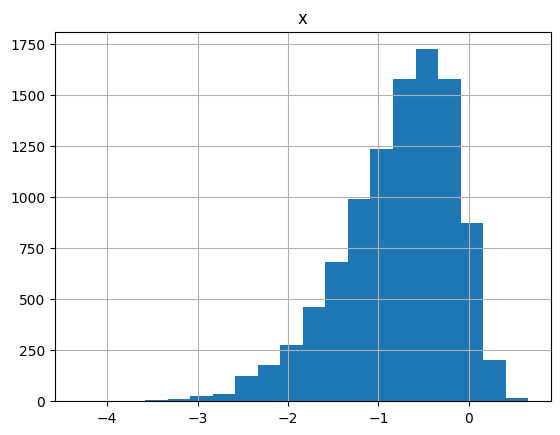

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skewnorm
# normal_variables = np.random.normal(size=10000)
skew = -4.5
normal_variables = skewnorm.rvs(skew,size=10000)
df = pd.DataFrame({'x':normal_variables})
mu = df.x.mean()
sigma = df.x.std()
s = np.array([
    ((v-mu)/sigma)**3
    for v in df.x.values
]).mean()
print(s, 100 - 10*skew,len([x for x in df.x if x<=-2])/10000)
df.hist(bins=20)

### Calculate `w` 
#### `w` is the dte for the combined "theoretcal option" made up of interpolating the 1st and 2nd option

In general, 30-day options are not available and S is derived by inter or extrapolation
from Snear and Snext, the prices of skewness at adjacent expirations:

S = w Snear + (1-w) Snext

where:
 * w = (Tnext- T30)/(Tnext- Tnear)
 * Tnear, Tnext and T30 are the times to expiration of the near and next term options expressed in minutes
 * T is the number of minutes in 30 days.
 
To streamline exposition, in what follows, S refers to either Snear or Snext.


August 2010 options expire on the 20th and September 2010 options
expire on the 17th . At 10:45 am on July 28, 2010, the times to expiration
of August and September 2010 options are equal to 0.065 and 0.142. 

In [17]:
Tnear,Tnext
print((datetime.datetime(2010,8,20,9,0) - datetime.datetime(2010,7,28,10,45)))
print((datetime.datetime(2010,9,17,9,0) - datetime.datetime(2010,7,28,10,45)))

22 days, 22:15:00
50 days, 22:15:00


In [24]:
minutes_per_year = 365*24*60
Snear = None
Snext = None
Tnear_td = (datetime.datetime(2010,8,20,9,30) - datetime.datetime(2010,7,28,10,45))
Tnext_td = (datetime.datetime(2010,9,17,9,30) - datetime.datetime(2010,7,28,10,45))
Tnear = (Tnear_td.days*24*60 + Tnear_td.seconds/60)/minutes_per_year
Tnext = (Tnext_td.days*24*60 + Tnext_td.seconds/60)/minutes_per_year
T30 = 30*24*60/minutes_per_year
w = (Tnext - T30)/(Tnext - Tnear)
w,Tnear,Tnext

(0.748139880952381, 0.06287100456621005, 0.13958333333333334)

### Calcuate risk-free interest  rate `r` used: 

The second piece of data to calculate interest rate discount factors is the risk-free interest rate, `r`. 

`r` is the bond-equivalent yield of the U.S. Tbill maturing closest to the expiration dates of relevant SPX options. As such, the SKEW calculation may use different risk-free interest rates for near- and next-term
options.

In this example, `R = 0.00155` for both sets of options

In [25]:
R = 0.00155

### Calculation of S&P 500 forward price and determination of at-the-money strike

Similar to VIX, SKEW is calculated from at and out-of-the-money puts and calls. 

The atthe-money strike is defined as:
 * the listed strike immediately below the S&P 500 forward price. 
 
#### To find the forward price: 
 1. Find the strike for which the difference between the midquotes of the call and put is at a minimum. 
 1. Then calculate the forward price as `F = erT * (C – P) +K`, where `T` is the time to expiration, `C` and `P` are the call and put midquotes, and `K` is the strike at which minimum occurs.
 
As seen in Table 1 below, for August 2010 options: 

 * the strike at which the minimum of the midquote difference is attained is 1105. 
 * The 1105 row is highlighted in green. 
 * The forward price for August 2010 is equal to: 
   * `FAug = exp(00155) * 0.65 * (23.7 – 21.85) + 1105`
   *  `FAug = 1106.85`
 * The strike for September 2010 options also turns out to be 1105. 
 * By a similar calculation:
   * `FSep = 1106.45` 
 * Thus, the at-the-money strike for both August and September is `1105`.  The options that will be included in the calculation are:
   * Puts at `1105` or below and 
   * Calls at `1105` or above
 

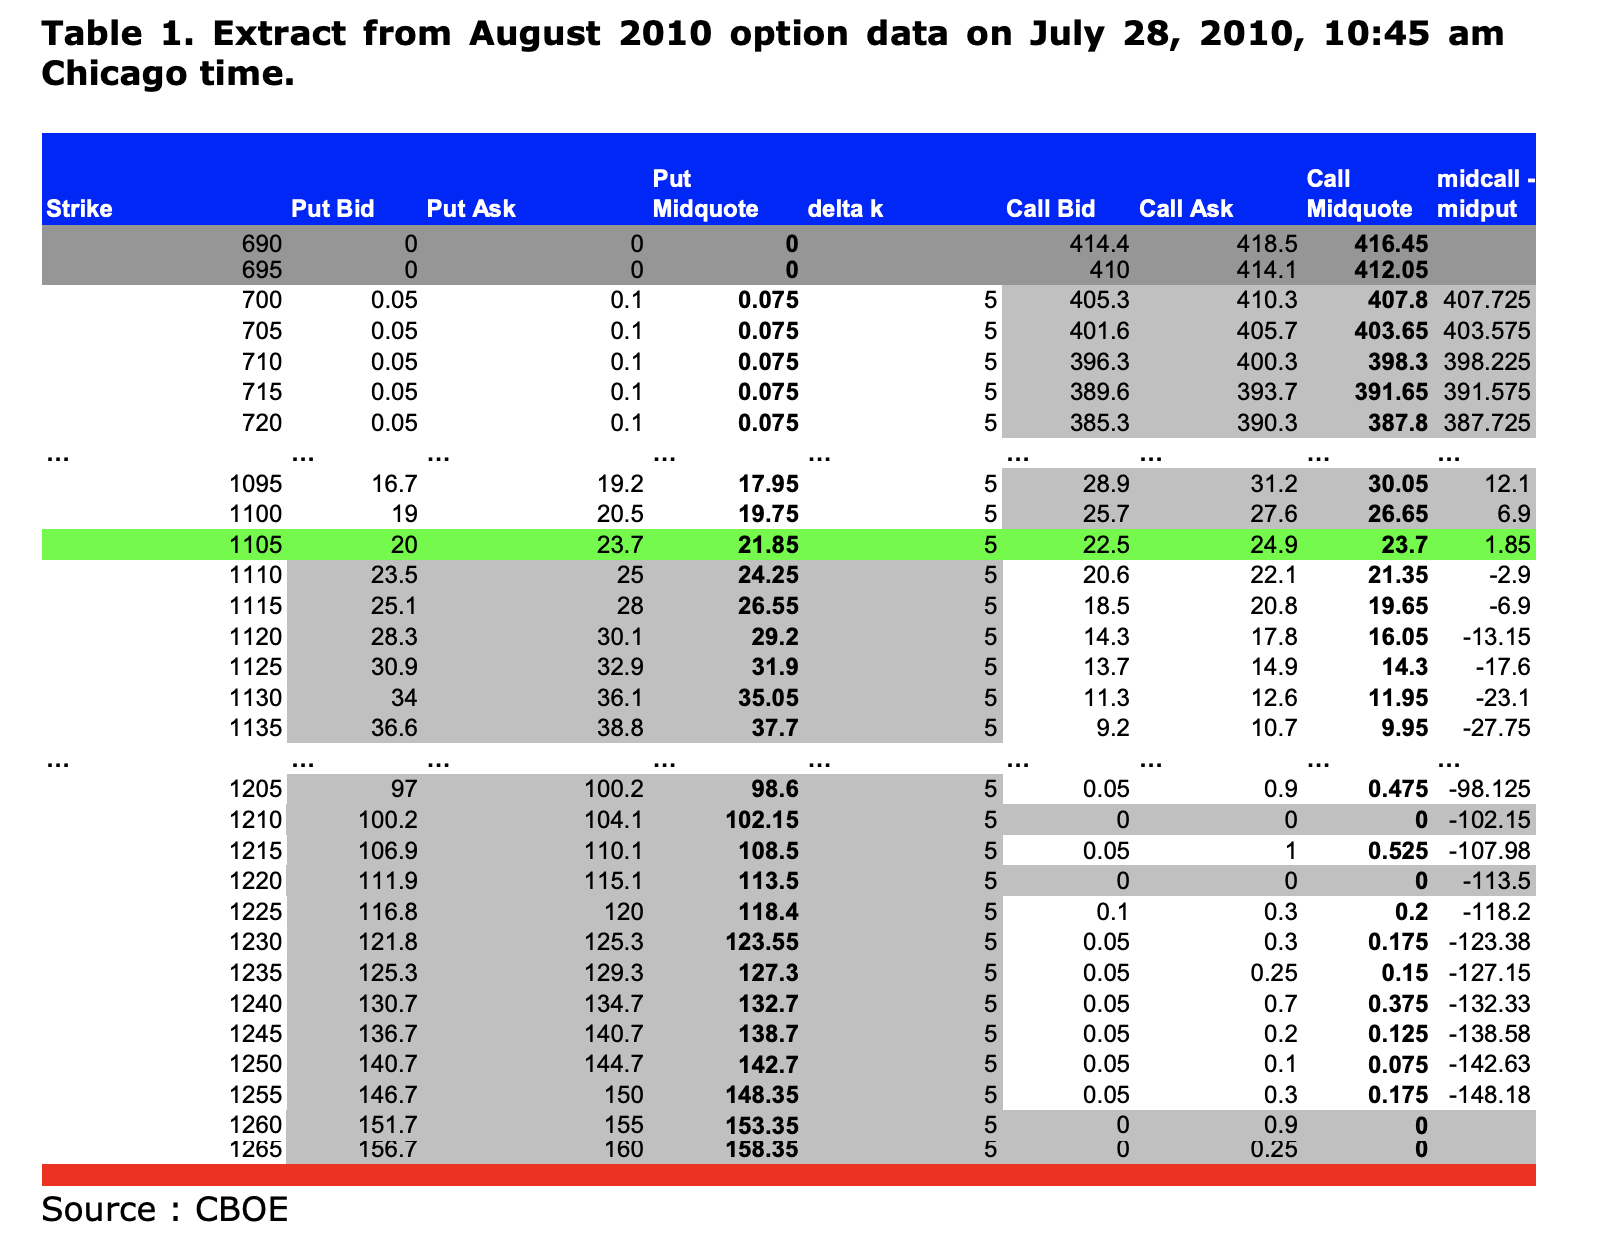

### Rules for the elimination of strikes:

1. The SKEW calculation only uses at or out-of-the money strikes. 
2. In addition, only options with non-zero bid prices are used.
3. Once two consecutive puts with 0 bid prices are found, all puts with lower strike prices are eliminated. 
4. Similarly, once two consecutive calls with 0 bid prices are found, all calls with higher strike prices are eliminated. 

In Table 1, all data for eliminated strikes are grayed out, and puts and calls eliminated because they were below and above two consecutive strikes with zero bids are not shown. 

Data for strikes ranging from `720 to 1095` and from `1135 to 1205` are replaced by dots (…) to provide a more compact display.

For August 2010 options, this elimination process leaves:
 * puts with strikes from `700 to 1105` and 
 * calls with strikes from `1105 to 1255` 
 * Also **leaves out** calls with strikes `1210 and 1220` because they have 0 bids. 
 
For September 2010 options, use: 
 * puts with strikes from `725 to 1105` and 
 * calls with strikes from `1105 to 1280`

### Step 2 – Calculate SKEW for both near-term and next-term options

Recall that SKEW = 100 – 10 S, where S the price of skewness can be derived from
the prices of S&P 500 options:

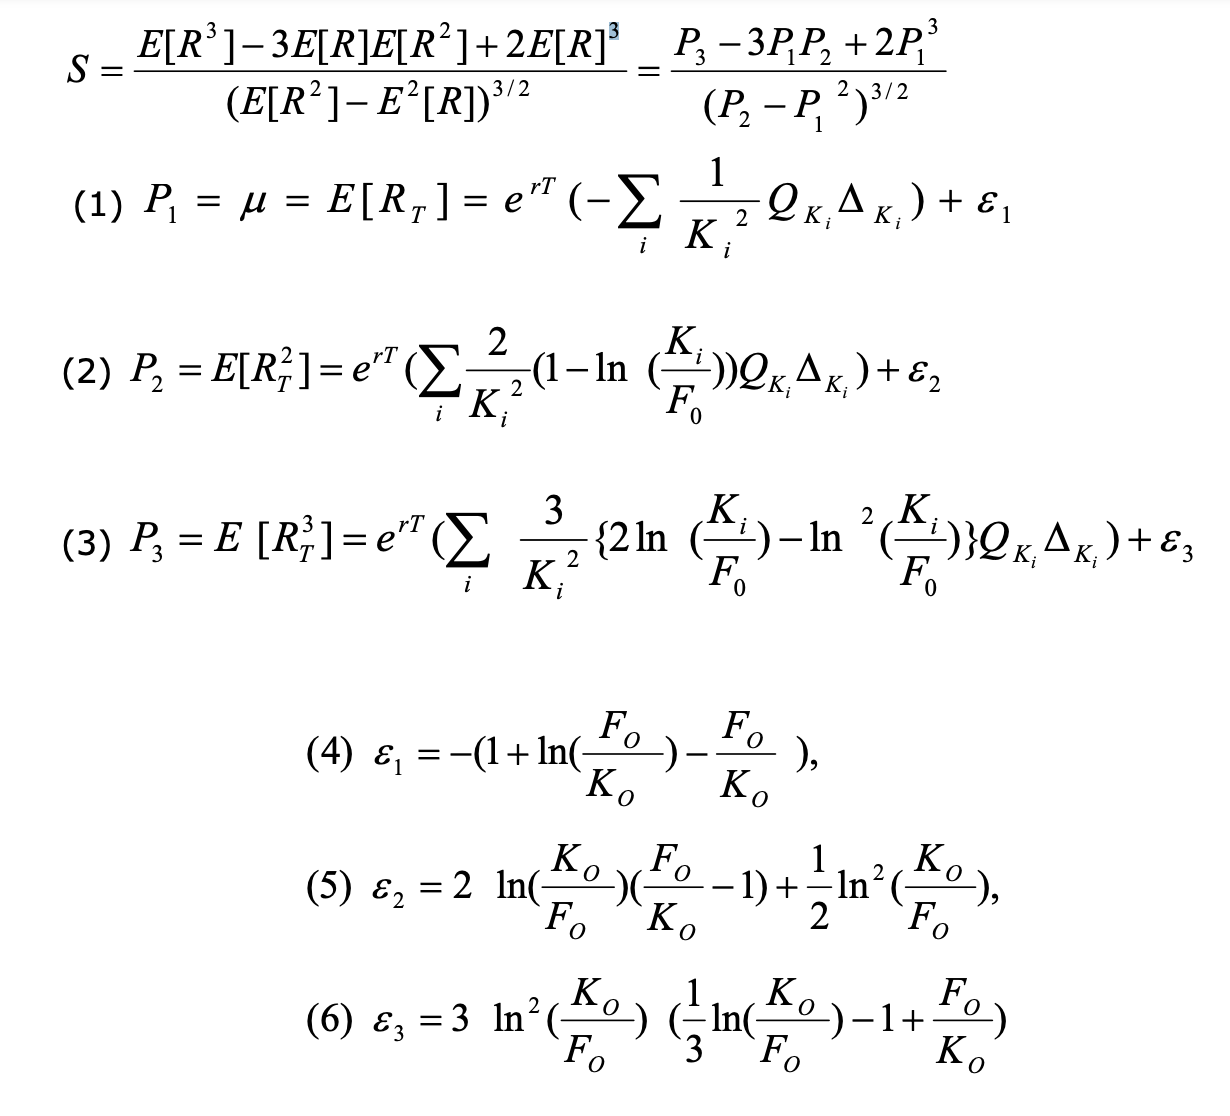

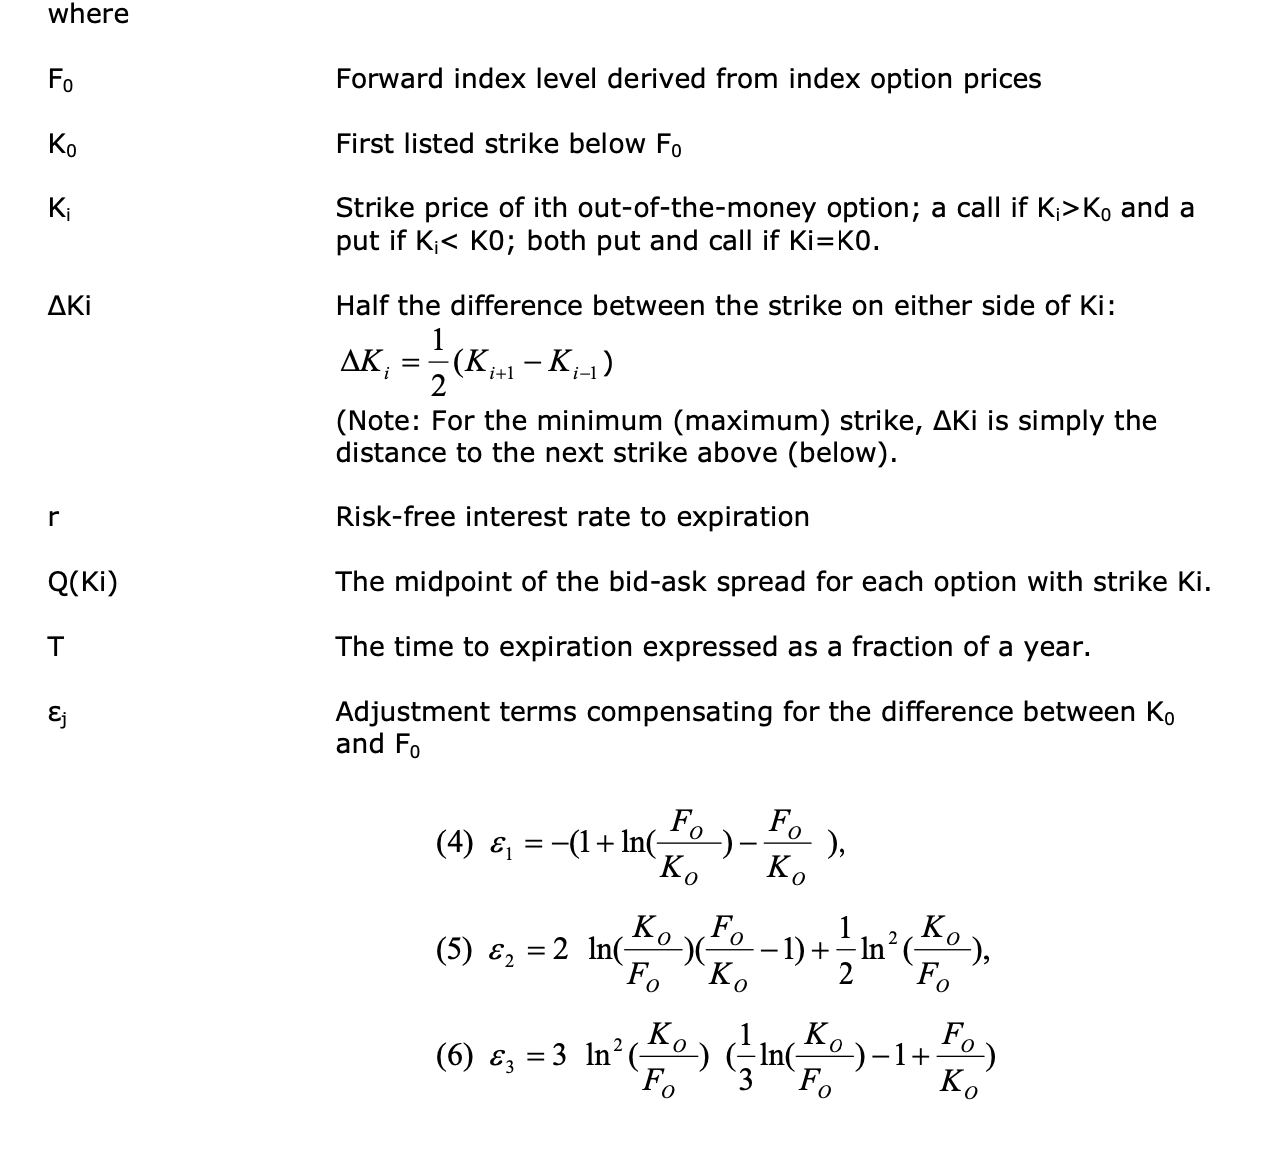

In [ ]:
i_puts = 1105 - 705
for i in range(i_puts):
    s1 = sum(
        [
            k_i * q_k_i * delta_k_i
        ]
    )
S = exp(r*T) * (-1* s1 * err1

In [4]:
yo_spy = yopt.YahooOptions('SPY')

[*********************100%***********************]  1 of 1 completed


In [6]:
df_spy_all_hist_calls = yo_spy.get_options_all_strikes_in_hist(
    datetime.datetime(2023,3,17)
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
df_spy_all_hist_calls['yyyymmdd'] = [
    yopt.get_yyyymmdd(d)
    for d in df_spy_all_hist.index
]


In [13]:
df_spy_all_hist_calls = df_spy_all_hist.copy()

In [14]:
df_spy_all_hist_calls[df_spy_all_hist_calls.yyyymmdd==df_spy_all_hist_calls.yyyymmdd.max()]

,open,high,low,option,adj_close,volume,underlying,strike,pc,expiry_date,rate,iv,yyyymmdd
Date,,,,,,,,,,,,,
2023-02-24 00:00:00-05:00,20.500000,21.799999,20.500000,21.58,21.58,8,396.380005,377,C,2023-03-17,0.04,0.235747,20230224
2023-02-24 00:00:00-05:00,20.240000,20.620001,20.180000,20.18,20.18,17,396.380005,379,C,2023-03-17,0.04,0.242320,20230224
2023-02-24 00:00:00-05:00,19.180000,20.000000,17.850000,19.52,19.52,162,396.380005,380,C,2023-03-17,0.04,0.245903,20230224
2023-02-24 00:00:00-05:00,18.629999,18.770000,18.629999,18.77,18.77,15,396.380005,381,C,2023-03-17,0.04,0.245729,20230224
2023-02-24 00:00:00-05:00,18.629999,18.770000,18.629999,18.77,18.77,15,396.380005,381,C,2023-03-17,0.04,0.245729,20230224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-24 00:00:00-05:00,1.270000,1.480000,1.140000,1.35,1.35,761,396.380005,413,C,2023-03-17,0.04,0.169902,20230224
2023-02-24 00:00:00-05:00,1.270000,1.480000,1.140000,1.35,1.35,761,396.380005,413,C,2023-03-17,0.04,0.169902,20230224
2023-02-24 00:00:00-05:00,1.110000,1.280000,0.990000,1.14,1.14,5152,396.380005,414,C,2023-03-17,0.04,0.166888,20230224


In [15]:
df_spy_all_hist_puts = yo_spy.get_options_all_strikes_in_hist(
    datetime.datetime(2023,3,17),
    pc='P'
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [16]:
df_spy_all_hist_puts

,open,high,low,option,adj_close,volume,underlying,strike,pc,expiry_date,rate,iv
Date,,,,,,,,,,,,
2022-11-18 00:00:00-05:00,12.190000,12.690000,12.190000,12.690000,12.690000,339,396.029999,377,P,2023-03-17,0.04,0.238919
2022-11-21 00:00:00-05:00,12.750000,12.750000,12.460000,12.460000,12.460000,49,394.589996,377,P,2023-03-17,0.04,0.233111
2022-11-22 00:00:00-05:00,11.770000,11.860000,10.610000,10.610000,10.610000,107,399.899994,377,P,2023-03-17,0.04,0.231984
2022-11-23 00:00:00-05:00,10.390000,10.410000,9.680000,9.780000,9.780000,804,402.420013,377,P,2023-03-17,0.04,0.231677
2022-11-25 00:00:00-05:00,9.630000,9.630000,9.630000,9.630000,9.630000,1,402.329987,377,P,2023-03-17,0.04,0.231360
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 00:00:00-05:00,14.500000,15.620000,13.230000,13.250000,13.250000,1108,407.260010,417,P,2023-03-17,0.04,0.163110
2023-02-21 00:00:00-05:00,16.280001,19.260000,16.280001,19.260000,19.260000,421,399.089996,417,P,2023-03-17,0.04,0.167558
2023-02-22 00:00:00-05:00,19.170000,20.930000,18.440001,20.690001,20.690001,566,398.540009,417,P,2023-03-17,0.04,0.208474


In [17]:
df_spy_all_hist_puts['yyyymmdd'] = [
    yopt.get_yyyymmdd(d)
    for d in df_spy_all_hist_puts.index
]


In [83]:
c1 = df_spy_all_hist_calls.yyyymmdd==df_spy_all_hist_calls.yyyymmdd.max()
dfc_final = df_spy_all_hist_calls[c1].drop_duplicates().copy()
c1 = df_spy_all_hist_puts.yyyymmdd==df_spy_all_hist_puts.yyyymmdd.max()
dfp_final = df_spy_all_hist_puts[c1].drop_duplicates().copy()

In [84]:
dfc_final = dfc_final[['strike','option','iv']].rename(
    columns={'option':'call','iv':'call_iv'}
)
dfp_final = dfp_final[['strike','option','iv']].rename(
    columns={'option':'put','iv':'put_iv'}
)


In [85]:
df_final = dfc_final.merge(dfp_final,on='strike',how='left')
df_final['underlying'] = df_spy_all_hist_puts[c1].underlying.values[0]

<AxesSubplot: xlabel='strike'>

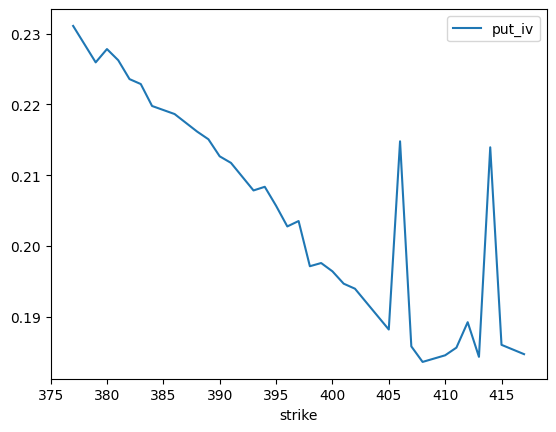

In [56]:
df_final[['strike','put_iv']].plot(x='strike',y='put_iv')

<AxesSubplot: xlabel='strike'>

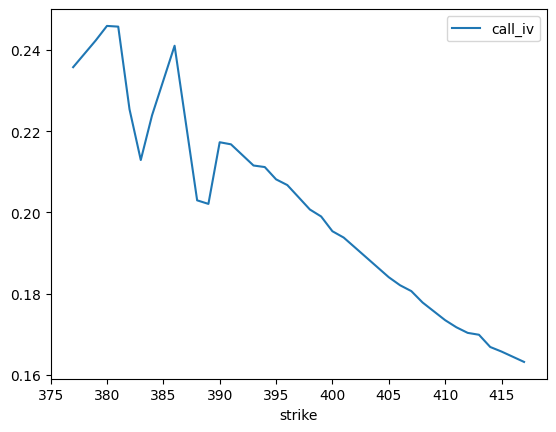

In [57]:
df_final[['strike','call_iv']].plot(x='strike',y='call_iv')

In [87]:
df_final['otm_iv'] = df_final.apply(
    lambda row: row.put_iv if (row.strike<=row.underlying) else row.call_iv,
    axis=1
)
df_final['otm_price'] = df_final.apply(
    lambda row: row.put if (row.strike<=row.underlying) else row.call,
    axis=1
)


In [66]:
df_final

,strike,call,call_iv,put,put_iv,otm_iv,otm_price
0,377,21.58,0.235747,2.130000,0.231112,0.231112,2.13
1,379,20.18,0.242320,2.400000,0.225957,0.225957,2.40
2,380,19.52,0.245903,2.670000,0.227837,0.227837,2.67
3,381,18.77,0.245729,2.860000,0.226258,0.226258,2.86
4,382,17.43,0.225398,3.030000,0.223590,0.223590,3.03
5,383,16.32,0.212902,3.270000,0.222889,0.222889,3.27
6,384,15.93,0.223909,3.450000,0.219788,0.219788,3.45
7,386,15.11,0.241026,4.010000,0.218646,0.218646,4.01
8,388,12.50,0.202980,4.590000,0.216163,0.216163,4.59
9,389,11.82,0.202104,4.910000,0.215077,0.215077,4.91


<AxesSubplot: xlabel='strike'>

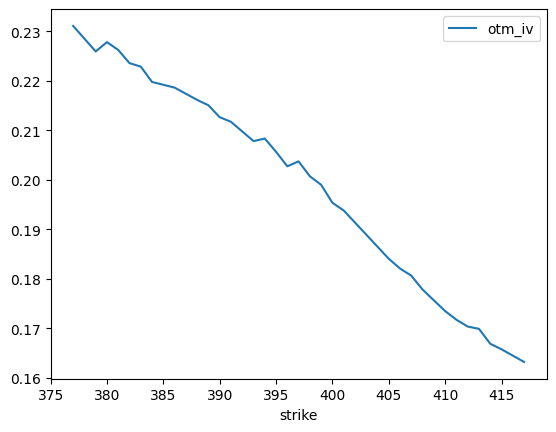

In [88]:
df_final[['strike','otm_iv']].plot(x='strike',y='otm_iv')

In [94]:
c1 = (df_final.call - df_final.put).abs() == (df_final.call - df_final.put).abs().min()
F0 = df_final[c1].underlying.values[0]
K0 = df_final[c1].strike.values[0]

0.002

In [272]:
T = (datetime.datetime(2023,3,17) - datetime.datetime(2023,2,24)).days/365
e1 = -1 * (1 + np.log(F0/K0) - F0/K0)
e2 = 2 * np.log(K0/F0) * (F0/K0 - 1) * 1/2 * np.log(K0/F0)**2
e3 = 3 * np.log(K0/F0)**2 * (1/3*np.log(K0/F0) - 1 + F0/K0)


P1 = np.exp(.04*T) * -1 * (df_final.otm_price/df_final.strike).sum() 

def p2(row,T=T):
    t = np.exp(.04*T)
    t1 = 2/row.strike**2
    t2 = (1 - np.log(row.strike/row.underlying)) * row.otm_price
    return t * t1 * t2

P2 = df_final.apply(p2,axis=1).sum()

def p3(row,T=T):
    t = np.exp(.04*T)
    t1 = 3/row.strike**2
    t2 = 2*np.log(row.strike/396) - np.log(row.strike/row.underlying)**2
    t2 = t2 * row.otm_price
    return t * t1 * t2

P3 = np.exp(.04*T) * ( 3/df_final.strike**2 * (2*np.log(df_final.strike/F0 - np.log(df_final.strike/F0)**2)) * df_final.otm_price ).sum()

S = (P3 - 3*P1*P2 + 2*P1**2) / (P2 - P1**2)**(3/2)
d = (P2 - P1**2)
if d<0:
    d = (d*-1)**(3/2) * -1


S = (P3 - 3*P1*P2 + 2*P1**2) / d

S,P1,P2,P3,e1,e2,e3





/var/folders/fl/tvtrn4x93cx6s2vpm9b7gn0w0000gn/T/ipykernel_24575/1962299017.py:26: RuntimeWarning: invalid value encountered in scalar power
  S = (P3 - 3*P1*P2 + 2*P1**2) / (P2 - P1**2)**(3/2)


(-6.265804755331021,
 -0.32912617562093127,
 0.0016742530664128137,
 -6.999934013756897e-05,
 -0.0,
 0.0,
 0.0)

In [120]:
P2-P1**2


-0.10664978641244727

/var/folders/fl/tvtrn4x93cx6s2vpm9b7gn0w0000gn/T/ipykernel_24575/1014405032.py:5: RuntimeWarning: invalid value encountered in scalar power
  r - (r**2 - x**2)**0.5


<AxesSubplot: xlabel='x', ylabel='y'>

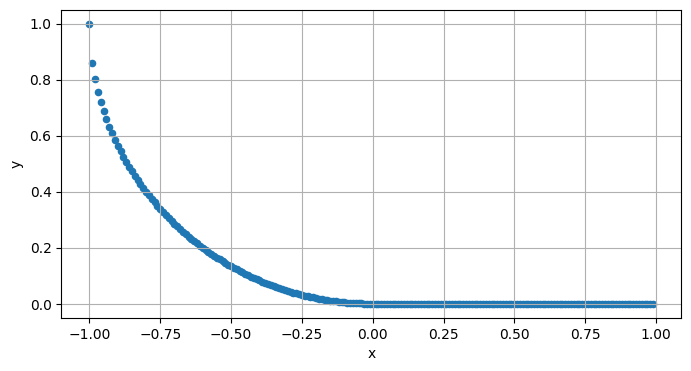

In [222]:
inc = 0.01
X = np.arange(-r,r+inc,inc)
r = 1
Y1 = [
    r - (r**2 - x**2)**0.5
    if (x<=0) else 0
    for x in X
]

Y = np.array(Y1)
df = pd.DataFrame({'x':X,'y':Y})
df = df[(df.x>=-1) & (df.x<=1)]
# df.y = df.y.fillna(1)
xsize = 8
df.plot.scatter(x='x',y='y',figsize=(xsize,xsize/(2*r)),grid=True)

In [215]:
df = pd.DataFrame({'x':X,'y':Y})
df[df.y.isna()]

,x,y


<AxesSubplot: xlabel='x', ylabel='y'>

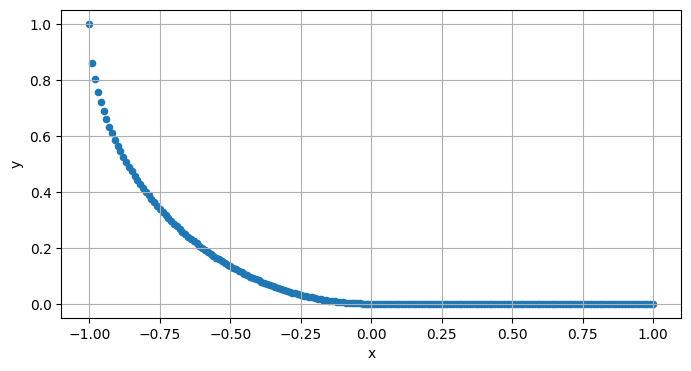

In [216]:
df = pd.DataFrame({'x':X,'y':Y})
# df.y = df.y.fillna(1)
df.plot.scatter(x='x',y='y',figsize=(8,4),grid=True)

<AxesSubplot: xlabel='x', ylabel='y'>

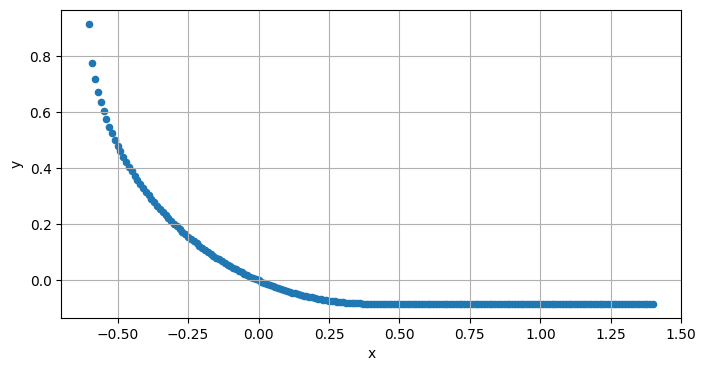

In [218]:
shift = .4
X2 = X+shift
Y2 = Y - (r - (r**2 - shift**2)**0.5)
df2 = pd.DataFrame({'x':X2,'y':Y2})
df2.y = df2.y.fillna(1)
df2.plot.scatter(x='x',y='y',figsize=(8,4),grid=True)

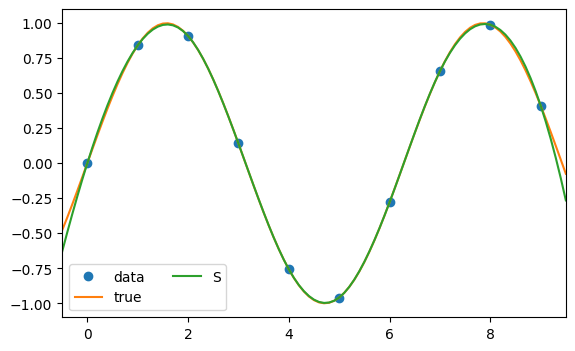

In [224]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
x = np.arange(10)
y = np.sin(x)
cs = CubicSpline(x, y)
xs = np.arange(-0.5, 9.6, 0.1)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(xs, np.sin(xs), label='true')
ax.plot(xs, cs(xs), label="S")
# ax.plot(xs, cs(xs, 1), label="S'")
# ax.plot(xs, cs(xs, 2), label="S''")
# ax.plot(xs, cs(xs, 3), label="S'''")
ax.set_xlim(-0.5, 9.5)
ax.legend(loc='lower left', ncol=2)
plt.show()

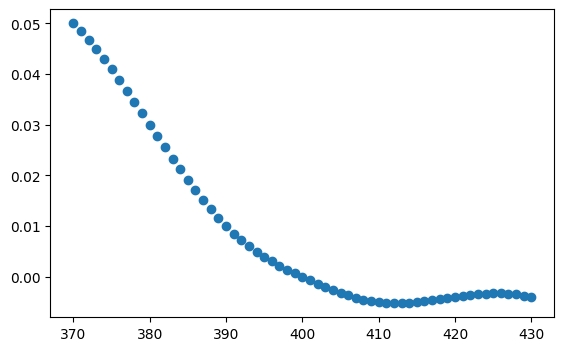

In [246]:
days = 25
rate = .04
atm_price = 400
otm_strikes = 30
low_strike = atm_price - otm_strikes
high_strike = atm_price + otm_strikes
x_cs = np.arange(low_strike,high_strike+10,10)
skew_array = np.array([.05,.03,.01,0,-.005,-.004,-.004])
y_cs = skew_array
cs2 = CubicSpline(x_cs, y_cs)
strikes = np.arange(low_strike,high_strike+1,1)
skews = cs2(x)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(strikes, skews, 'o', label='data')


In [247]:
df_xy = pd.DataFrame({'x':strikes,'y':skews})
vals = np.array(
    [
        pblack.black_scholes(
            'c' if (df_xy.iloc[i].x>atm_price) else 'p', 
            atm_price, df_xy.iloc[i].x, days/365, rate, df_xy.iloc[i].y + .2
        )
        for i in range(len(df_xy))
    ]
)
df_opts = pd.DataFrame({'strike':df_xy.x.values,'otm_price':vals})
df_opts['underlying'] = 400
df_opts


,strike,otm_price,underlying
0,370,1.315704,400
1,371,1.403272,400
2,372,1.493633,400
3,373,1.587073,400
4,374,1.683933,400
...,...,...,...
56,426,1.266242,400
57,427,1.153756,400
58,428,1.048246,400
59,429,0.949301,400


In [248]:
df_final.head()

,strike,call,call_iv,put,put_iv,underlying,otm_iv,otm_price
0,377,21.58,0.235747,2.13,0.231112,396.380005,0.231112,2.13
1,379,20.18,0.242320,2.40,0.225957,396.380005,0.225957,2.40
2,380,19.52,0.245903,2.67,0.227837,396.380005,0.227837,2.67
3,381,18.77,0.245729,2.86,0.226258,396.380005,0.226258,2.86
4,382,17.43,0.225398,3.03,0.223590,396.380005,0.223590,3.03


In [273]:
T = days/365
F0 = atm_price
K0 = F0
e1 = -1 * (1 + np.log(F0/K0) - F0/K0)
e2 = 2 * np.log(K0/F0) * (F0/K0 - 1) * 1/2 * np.log(K0/F0)**2
e3 = 3 * np.log(K0/F0)**2 * (1/3*np.log(K0/F0) - 1 + F0/K0)


P1 = np.exp(.04*T) * -1 * (df_opts.otm_price/df_opts.strike).sum() 

def p2(row,T=T):
    t = np.exp(.04*T)
    t1 = 2/row.strike**2
    t2 = (1 - np.log(row.strike/row.underlying)) * row.otm_price
    return t * t1 * t2

P2 = df_opts.apply(p2,axis=1).sum()

def p3(row,T=T):
    t = np.exp(.04*T)
    t1 = 3/row.strike**2
    t2 = 2*np.log(row.strike/396) - np.log(row.strike/row.underlying)**2
    t2 = t2 * row.otm_price
    return t * t1 * t2

P3 = np.exp(.04*T) * ( 3/df_opts.strike**2 * (2*np.log(df_opts.strike/F0 - np.log(df_opts.strike/F0)**2)) * df_opts.otm_price ).sum()

# S = (P3 - 3*P1*P2 + 2*P1**2) / (P2 - P1**2)**(3/2)
d = (P2 - P1**2)
if d<0:
    d = (d*-1)**(3/2) * -1
#     d = d**(3/2)
#     d = d*-1


S = (P3 - 3*P1*P2 + 2*P1**2) / d

S,P1,P2,P3,e1,e2,e3





(-3.68726775463963,
 -0.5540002029680947,
 0.00278842527843658,
 -3.92262882568983e-05,
 -0.0,
 0.0,
 0.0)

(-6.265804755331021,
 -0.32912617562093127,
 0.0016742530664128137,
 -6.999934013756897e-05,
 -0.0,
 0.0,
 0.0)

In [442]:
v = '''
<!DOCTYPE html>
<html lang="en"><head><meta charSet="UTF-8"/><meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=no"/><meta name="theme-color" content="#000000"/><title>Wordle - The New York Times</title><link rel="manifest" href="https://www.nytimes.com/games-assets/v2/metadata/wordle-web-manifest.json?v=v2302281258"/><link rel="apple-touch-icon" sizes="180x180" href="https://www.nytimes.com/games-assets/v2/metadata/wordle-apple-touch-icon.png?v=v2302281258"/><link rel="mask-icon" color="#FFFFFF" href="https://www.nytimes.com/games-assets/v2/metadata/wordle-safari-pinned-tab.svg?v=v2302281258"/><link rel="shortcut icon" href="https://www.nytimes.com/games-assets/v2/metadata/wordle-favicon.ico?v=v2302281258"/><link href="https://www.nytimes.com/games-assets/v2/assets/wordle/wordle_logo_32x32.png" rel="icon shortcut" sizes="3232"/><link href="https://www.nytimes.com/games-assets/v2/assets/wordle/wordle_logo_192x192.png" rel="apple-touch-icon"/><meta name="apple-mobile-web-app-title" content="Wordle"/><meta name="application-name" content="Wordle"/><meta name="msapplication-TileColor" content="#FFFFFF"/><meta name="theme-color" content="#FFFFFF"/><meta name="sourceApp" content="games-crosswords"/><meta property="description" content="Guess the hidden word in 6 tries. A new puzzle is available each day."/><meta property="og:title" content="Wordle - A daily word game"/><meta property="og:url" content="https://www.nytimes.com/games/wordle"/><meta property="og:description" content="Guess the hidden word in 6 tries. A new puzzle is available each day."/><meta property="og:image" content="https://www.nytimes.com/games-assets/v2/assets/wordle/wordle_og_1200x630.png"/><meta property="twitter:card" content="summary_large_image"/><meta property="twitter:domain" content="nytimes.com"/><meta property="theme-color" content="#6aaa64"/><link rel="stylesheet" type="text/css" href="https://www.nytimes.com/games-assets/v2/wordle.f6e59635da6e07c2eb50.css"/></head><body><script type="text/javascript">(function Qo(){let e;try{e=JSON.parse(localStorage.getItem("nyt-wordle-darkmode"))}catch(e){}e&&document.body.classList.add("dark")})();</script><script type="text/javascript">window.pageName = "wordle"</script><script type="text/javascript">window.env = {"version":"v2302281258","api":"https:\u002F\u002Fedge.games.nyti.nyt.net","tagx":"https:\u002F\u002Fa.nytimes.com","gtm":"https:\u002F\u002Fwww.googletagmanager.com\u002Fgtm.js?id=GTM-P528B3&gtm_auth=tfAzqo1rYDLgYhmTnSjPqw&gtm_preview=env-130&gtm_cookies_win=x","hostname":"https:\u002F\u002Fwww.nytimes.com","edge":"https:\u002F\u002Fwww.nytimes.com","account":"https:\u002F\u002Fmyaccount.nytimes.com","name":"prod"}</script><script type="text/javascript">window.abra = {"config":{".ver":11761,"TEST_sharedPhoenix_0930":{"abtest_partition":[{"var":"agent_id"},"TEST_sharedPhoenix_0930",2147483647,"0_Control",4294967295,"1_sharedTreated"]},"ON_wordle_regi_modal":{"abtest_partition":[{"var":"agent_id"},"ON_wordle_regi_modal",4294967295,"1_regi_modal"]},"ON_wordleOnboardingOffer_0822":{"abtest_partition":[{"var":"agent_id"},"ON_wordleOnboardingOffer_0822",4294967295,"1_ShowOffer"]},"MKT_Spellingbee_banner_test_sub_0522":{"abtest_partition":[{"var":"agent_id"},"MKT_Spellingbee_banner_test_sub_0522",4294967295,"1_gift"]},"MKT_ADAGamesSaleBanner_012023":{"abtest_partition":[{"var":"agent_id"},"MKT_ADAGamesSaleBanner_012023",4294967295,"0_Control"]},"GAMES_wordle_welcome_app_cta_external":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordle_welcome_app_cta_external",4080218930,"2_Welcome_Download_App_Banner"]},"GAMES_wordle_welcome_app_cta":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordle_welcome_app_cta",4080218930,"1_Display_Cta"]},"GAMES_wordleWelcomeMoment_0621":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordleWelcomeMoment_0621",4294967295,"1_EnableWordleWelcomeMoment"]},"GAMES_wordleWBCTA_0223":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordleWBCTA_0223",1073741823,"0_control",2147483647,"1_beatWB",3221225471,"2_rateGame",4294967295,"3_guessAnalysis"]},"GAMES_wordleSolutionV2BE_0817":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordleSolutionV2BE_0817",4294967295,"1_EnableV2ServerSolution"]},"GAMES_wordleSolutionBE_0510":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordleSolutionBE_0510",4294967295,"1_EnableServerSolution"]},"GAMES_wordleSBCTA_0223":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordleSBCTA_0223",4294967295,"2_sbEmphasisPlay"]},"GAMES_wordleRollout_0419":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordleRollout_0419",2147483647,"0_control",4294967295,"0_control"]},"GAMES_wordleProgress_0922":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordleProgress_0922",85899345,null]},"GAMES_wordleMoogle_0422":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordleMoogle_0422",429496729,"1_EnableMoogle",4294967295,"1_EnableMoogle"]},"GAMES_wordleCCPA_0427":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordleCCPA_0427",4294967295,"1_EnableCCPA"]},"GAMES_wordleAuth_0427":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordleAuth_0427",21474835,"1_EnableAuth",42949672,"1_EnableAuth",429496729,"1_EnableAuth",450971565,"1_EnableAuth",536870911,"1_EnableAuth",601295420,"1_EnableAuth",665719930,"1_EnableAuth",730144439,"1_EnableAuth",773094112,"1_EnableAuth",794568949,"1_EnableAuth",837518622,"1_EnableAuth",858993458,"1_EnableAuth",880468295,"1_EnableAuth",901943131,"1_EnableAuth",923417968,"1_EnableAuth",944892804,"1_EnableAuth",966367641,"1_EnableAuth",987842477,"1_EnableAuth",1009317314,"1_EnableAuth",1030792150,"1_EnableAuth",1052266987,"1_EnableAuth",1073741823,"1_EnableAuth",1095216659,"1_EnableAuth",1116691496,"1_EnableAuth",1181116005,"1_EnableAuth",1245540515,"1_EnableAuth",1309965024,"1_EnableAuth",1395864370,"1_EnableAuth",1438814043,"1_EnableAuth",1460288880,"1_EnableAuth",1481763716,"1_EnableAuth",1503238553,"1_EnableAuth",1524713389,"1_EnableAuth",1546188226,"1_EnableAuth",1567663062,"1_EnableAuth",1610612735,"1_EnableAuth",1632087571,"1_EnableAuth",1675037244,"1_EnableAuth",1717986917,"1_EnableAuth",1782411427,"1_EnableAuth",1889785609,"1_EnableAuth",1932735282,"1_EnableAuth",1975684955,"1_EnableAuth",2018634628,"1_EnableAuth",2040109465,"1_EnableAuth",2104533974,"1_EnableAuth",2126008811,"1_EnableAuth",4294967295,"1_EnableAuth"]},"GAMES_wordleAppDownloadCTA_0323":{"abtest_partition":[{"var":"agent_id"},"GAMES_wordleAppDownloadCTA_0323",2147483647,null,4294967295,null]},"GAMES_sudoku_welcome_1101":{"abtest_partition":[{"var":"agent_id"},"GAMES_sudoku_welcome_1101",42949672,"1_NewSudokuWelcome",64424508,"1_NewSudokuWelcome",85899345,"1_NewSudokuWelcome",107374181,"1_NewSudokuWelcome",128849018,"1_NewSudokuWelcome",150323854,"1_NewSudokuWelcome",171798691,"1_NewSudokuWelcome",193273527,"1_NewSudokuWelcome",214748364,"1_NewSudokuWelcome",236223200,"1_NewSudokuWelcome",257698037,"1_NewSudokuWelcome",279172873,"1_NewSudokuWelcome",300647710,"1_NewSudokuWelcome",322122546,"1_NewSudokuWelcome",343597383,"1_NewSudokuWelcome",365072219,"1_NewSudokuWelcome",386547056,"1_NewSudokuWelcome",408021892,"1_NewSudokuWelcome",429496729,"1_NewSudokuWelcome",450971565,"1_NewSudokuWelcome",472446402,"1_NewSudokuWelcome",493921238,"1_NewSudokuWelcome",515396075,"1_NewSudokuWelcome",536870911,"1_NewSudokuWelcome",558345747,"1_NewSudokuWelcome",579820584,"1_NewSudokuWelcome",601295420,"1_NewSudokuWelcome",622770257,"1_NewSudokuWelcome",644245093,"1_NewSudokuWelcome",665719930,"1_NewSudokuWelcome",687194766,"1_NewSudokuWelcome",708669603,"1_NewSudokuWelcome",730144439,"1_NewSudokuWelcome",751619276,"1_NewSudokuWelcome",773094112,"1_NewSudokuWelcome",794568949,"1_NewSudokuWelcome",816043785,"1_NewSudokuWelcome",837518622,"1_NewSudokuWelcome",858993458,"1_NewSudokuWelcome",880468295,"1_NewSudokuWelcome",901943131,"1_NewSudokuWelcome",923417968,"1_NewSudokuWelcome",944892804,"1_NewSudokuWelcome",966367641,"1_NewSudokuWelcome",987842477,"1_NewSudokuWelcome",1009317314,"1_NewSudokuWelcome",1030792150,"1_NewSudokuWelcome",4294967295,"1_NewSudokuWelcome"]},"GAMES_shared_modals_1101":{"abtest_partition":[{"var":"agent_id"},"GAMES_shared_modals_1101",21474835,"1_NewSharedModal",42949672,"1_NewSharedModal",64424508,"1_NewSharedModal",85899345,"1_NewSharedModal",107374181,"1_NewSharedModal",128849018,"1_NewSharedModal",150323854,"1_NewSharedModal",171798691,"1_NewSharedModal",193273527,"1_NewSharedModal",214748364,"1_NewSharedModal",236223200,"1_NewSharedModal",257698037,"1_NewSharedModal",279172873,"1_NewSharedModal",300647710,"1_NewSharedModal",322122546,"1_NewSharedModal",343597383,"1_NewSharedModal",365072219,"1_NewSharedModal",386547056,"1_NewSharedModal",408021892,"1_NewSharedModal",429496729,"1_NewSharedModal",450971565,"1_NewSharedModal",472446402,"1_NewSharedModal",493921238,"1_NewSharedModal",515396075,"1_NewSharedModal",536870911,"1_NewSharedModal",579820584,"1_NewSharedModal",687194766,"1_NewSharedModal",837518622,"1_NewSharedModal",987842477,"1_NewSharedModal",1245540515,"1_NewSharedModal",1331439861,"1_NewSharedModal",1438814043,"1_NewSharedModal",1567663062,"1_NewSharedModal",1632087571,"1_NewSharedModal",1675037244,"1_NewSharedModal",1739461754,"1_NewSharedModal",1760936590,"1_NewSharedModal",1803886263,"1_NewSharedModal",1825361100,"1_NewSharedModal",1846835936,"1_NewSharedModal",1889785609,"1_NewSharedModal",1932735282,"1_NewSharedModal",1997159792,"1_NewSharedModal",2061584301,"1_NewSharedModal",2104533974,"1_NewSharedModal",2126008811,"1_NewSharedModal",4294967295,"1_NewSharedModal"]},"GAMES_SB_welcome":{"abtest_partition":[{"var":"agent_id"},"GAMES_SB_welcome",4294967295,"1_Download_App_Banner"]},"GAMES_SB_tips":{"abtest_partition":[{"var":"agent_id"},"GAMES_SB_tips",4294967295,"1_TipsAndTricks"]},"GAMES_SB_stats_anon_flow":{"abtest_partition":[{"var":"agent_id"},"GAMES_SB_stats_anon_flow",4294967295,"1_anon_flow"]},"GAMES_SB_stats":{"abtest_partition":[{"var":"agent_id"},"GAMES_SB_stats",4294967295,"1_Weekly_Stats"]},"GAMES_SB_recap":{"abtest_partition":[{"var":"agent_id"},"GAMES_SB_recap",4294967295,"1_Today_Genius"]},"GAMES_SB_rank_modal":{"abtest_partition":[{"var":"agent_id"},"GAMES_SB_rank_modal",204010946,"1_Redesign",4080218930,"1_Redesign"]},"GAMES_SB_rank":{"abtest_partition":[{"var":"agent_id"},"GAMES_SB_rank",4294967295,"1_Yesterday"]},"GAMES_SB_past_puzzles":{"abtest_partition":[{"var":"agent_id"},"GAMES_SB_past_puzzles",4294967295,"0_Control"]},"GAMES_SB_app_custom_cta_0223":{"abtest_partition":[{"var":"agent_id"},"GAMES_SB_app_custom_cta_0223",2147483647,"0_Control",4294967295,"1_Custom"]},"GAMES_SBSharing_1122":{"abtest_partition":[{"var":"agent_id"},"GAMES_SBSharing_1122",408021892,"1_Share",2040109465,"1_Share",4294967295,"1_Share"]},"GAMES_SBCardRecap_0622":{"abtest_partition":[{"var":"agent_id"},"GAMES_SBCardRecap_0622",10737417,"0_Control",21474835,"1_RankOnly",32212254,"2_FoundWords",42949672,"3_Rank_FoundWords",64424508,"0_Control",85899345,"1_RankOnly",107374181,"2_FoundWords",128849018,"3_Rank_FoundWords",150323854,"0_Control",171798691,"1_RankOnly",193273527,"2_FoundWords",214748364,"3_Rank_FoundWords",322122546,"0_Control",429496729,"1_RankOnly",536870911,"2_FoundWords",644245093,"3_Rank_FoundWords",730144439,"0_Control",816043785,"1_RankOnly",901943131,"2_FoundWords",987842477,"3_Rank_FoundWords",1063004405,"0_Control",1138166332,"1_RankOnly",1213328260,"2_FoundWords",1288490188,"3_Rank_FoundWords",1385126952,"0_Control",1481763716,"1_RankOnly",1578400480,"2_FoundWords",1675037244,"3_Rank_FoundWords",1803886263,"0_Control",1932735282,"1_RankOnly",2061584301,"2_FoundWords",2190433320,"3_Rank_FoundWords",2276332666,"0_Control",2362232012,"1_RankOnly",2448131358,"2_FoundWords",2534030704,"3_Rank_FoundWords",2566242958,"0_Control",2598455213,"1_RankOnly",2630667468,"2_FoundWords",2662879723,"3_Rank_FoundWords",2695091977,"0_Control",2727304232,"1_RankOnly",2759516487,"2_FoundWords",2791728741,"3_Rank_FoundWords",2834678414,"0_Control",2877628087,"1_RankOnly",2920577760,"2_FoundWords",2963527433,"3_Rank_FoundWords",3027951943,"0_Control",3092376452,"1_RankOnly",3156800962,"2_FoundWords",3221225471,"3_Rank_FoundWords",3253437726,"0_Control",3285649980,"1_RankOnly",3317862235,"2_FoundWords",3350074490,"3_Rank_FoundWords",3371549326,"0_Control",3393024163,"1_RankOnly",3414498999,"2_FoundWords",3435973836,"3_Rank_FoundWords",3478923509,"0_Control",3521873182,"1_RankOnly",3564822855,"2_FoundWords",3607772528,"3_Rank_FoundWords",3650722201,"0_Control",3693671874,"1_RankOnly",3736621547,"2_FoundWords",3779571219,"3_Rank_FoundWords",3801046056,"0_Control",3822520892,"1_RankOnly",3843995729,"2_FoundWords",3865470565,"3_Rank_FoundWords",3876207984,"0_Control",3886945402,"1_RankOnly",3897682820,"2_FoundWords",3908420238,"3_Rank_FoundWords",3929895075,"0_Control",3951369911,"1_RankOnly",3972844748,"2_FoundWords",3994319584,"3_Rank_FoundWords",4015794421,"0_Control",4037269257,"1_RankOnly",4058744094,"2_FoundWords",4080218930,"3_Rank_FoundWords",4101693767,"0_Control",4123168603,"1_RankOnly",4144643440,"2_FoundWords",4166118276,"3_Rank_FoundWords",4176855694,"0_Control",4187593113,"1_RankOnly",4198330531,"2_FoundWords",4209067949,"3_Rank_FoundWords",4230542786,"0_Control",4252017622,"1_RankOnly",4273492459,"2_FoundWords",4294967295,"3_Rank_FoundWords"]},"GAMES_play_hybrid":{"abtest_partition":[{"var":"agent_id"},"GAMES_play_hybrid",4294967295,"1_Use_Hybrid"]},"GAMES_playtabTileOrder_1222":{"abtest_partition":[{"var":"agent_id"},"GAMES_playtabTileOrder_1222",8589934,"0_control",85899345,"0_control",137438952,"0_control",188978560,"0_control",257698037,"0_control",352187317,"0_control",446676598,"0_control",515396075,"0_control",601295420,"0_control",695784701,"0_control",747324309,"0_control",781684047,"0_control",841813589,"0_control",858993458,"0_control",4294967295,"0_control"]},"GAMES_clusterMigration_0513":{"abtest_partition":[{"var":"agent_id"},"GAMES_clusterMigration_0513",3865470565,"0_control",4294967295,"1_newCluster"]},"GAMES_BeginnerXWD_1122":{"abtest_partition":[{"var":"agent_id"},"GAMES_BeginnerXWD_1122",1073741823,"0_control",2147483647,"1_highCarousel",3221225471,"2_dropDown",4294967295,"3_lowCarousel"]},"GAMES_Banner_Hasbro":{"abtest_partition":[{"var":"agent_id"},"GAMES_Banner_Hasbro",4294967295,"1_Activated_Banner"]},"GAMES_BackToPlayTab_1222":{"abtest_partition":[{"var":"agent_id"},"GAMES_BackToPlayTab_1222",4294967295,"1_BackToPlayTab"]},"GAMES_abra_test_0821":{"abtest_partition":[{"var":"regi_id"},"GAMES_abra_test_0821",2147483647,"0_Control",4294967295,"0_Control"]},"dfp_wordle_ad":{"abtest_partition":[{"var":"agent_id"},"dfp_wordle_ad",429496,"0_control",858992,"0_control",1717986,"0_control",3435973,"0_control",10307921,"0_control",18468358,"0_control",28776280,"0_control",32212254,"0_control",34789234,"0_control",35648228,"0_control",37366214,"0_control",38654705,"0_control",39084201,"0_control",39513698,"0_control",40372692,"0_control",41661182,"0_control",42090679,"0_control",42520175,"0_control",42949672,"0_control",4294967295,"1_topad"]},"DFP_Prebid_Price_0722":{"abtest_partition":[{"var":"agent_id"},"DFP_Prebid_Price_0722",4294967295,"0_Control"]},"AUD_wordleShareUrl":{"abtest_partition":[{"var":"agent_id"},"AUD_wordleShareUrl",21474835,null,42949672,null]}},"tests":{}}</script><script type="text/javascript">window.adUnitPath = "wordle"</script><script type="text/javascript">window.navigationLinks = {"subscribe":{"daily":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=4QHQ6","archive":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=4QHQF","gameplay":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=4R67W","congrats":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=4XKYJ","spellingBeeCard":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7QXX9","spellingBeePaywall":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7RJKF","spellingBeeBanner":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7HHK8","spellingBeeCutoffStart":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7F9J7","spellingBeeCutoffStop":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=79XQU","spellingBeeCutoffWelcomeBack":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7KK8Q","vertexCongratsMomentMidStarterPack":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=989YK","vertexCongratsMomentEndOfStarterPack":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=9K9UL","vertexWelcomeMomentDailyPuzzle":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=9RXHL","vertexPreviewPageNonsubs":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=9J9RU","vertexTodaysPuzzle":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=9KK7K","vertexDefault":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=9HURJ","letterBoxedBanner":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7UHY9","letterBoxedCard":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=78UQ9","letterBoxedPaywall":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7JXU8","tilesWelcomeDesktop":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7U798","tilesWelcomeMobile":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7Y97X","tilesCongratsDesktop":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7Y8WW","tilesCongratsMobile":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7RYYF","tilesSettingsDesktop":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7XH8W","tilesSettingsMobile":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=7JR89","branding":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=9W9LL","default":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames?campaignId=4QHQ8"},"login":"https:\u002F\u002Fmyaccount.nytimes.com\u002Fauth\u002Fenter-email?redirect_uri=https%3A%2F%2Fwww.nytimes.com%2Fgames%2Fwordle%2Findex.html&response_type=cookie&client_id=games&application=crosswords","logout":"https:\u002F\u002Fmyaccount.nytimes.com\u002Fauth\u002Flogout?redirect_uri=https%3A%2F%2Fwww.nytimes.com%2Fgames%2Fwordle%2Findex.html","register":"https:\u002F\u002Fmyaccount.nytimes.com\u002Fauth\u002Fregister?redirect_uri=https%3A%2F%2Fwww.nytimes.com%2Fgames%2Fwordle%2Findex.html&response_type=cookie&client_id=games&application=crosswords","account":"https:\u002F\u002Faccount.nytimes.com","hub":"\u002Fcrosswords","archive":"\u002Fcrosswords\u002Farchive","daily":"\u002Fcrosswords\u002Fgame\u002Fdaily","mini":"\u002Fcrosswords\u002Fgame\u002Fmini","apps":"\u002Fcrosswords\u002Fapps","stats":"\u002Fpuzzles\u002Fstats","leaderboards":"\u002Fpuzzles\u002Fleaderboards","spellingBee":"\u002Fpuzzles\u002Fspelling-bee","wordle":"\u002Fgames\u002Fwordle\u002Findex.html","tiles":"\u002Fpuzzles\u002Ftiles","letterBoxed":"\u002Fpuzzles\u002Fletter-boxed","vertex":"\u002Fpuzzles\u002Fvertex","sudoku":"\u002Fpuzzles\u002Fsudoku","submission":"https:\u002F\u002Fnytimes.com\u002Farticle\u002Fsubmit-crossword-puzzles-the-new-york-times.html","sbForum":"https:\u002F\u002Fwww.nytimes.com\u002Fspotlight\u002Fspelling-bee-forum","home":"https:\u002F\u002Fwww.nytimes.com","wordplay":"https:\u002F\u002Fwww.nytimes.com\u002Fcolumn\u002Fwordplay","guide":"https:\u002F\u002Fwww.nytimes.com\u002Fguides\u002Fcrosswords\u002Fhow-to-solve-a-crossword-puzzle","gift":"https:\u002F\u002Fwww.nytimes.com\u002Fsubscription\u002Fgames\u002Fgift","privacy":"https:\u002F\u002Fwww.nytimes.com\u002Fprivacy\u002Fprivacy-policy","faq":"https:\u002F\u002Fhelp.nytimes.com\u002Fhc\u002Fen-us\u002Farticles\u002F115014755667-New-York-Times-Crossword","shop":"https:\u002F\u002Fstore.nytimes.com\u002Fcollections\u002Fgames","termsOfService":"https:\u002F\u002Fhelp.nytimes.com\u002Fhc\u002Fen-us\u002Farticles\u002F115014893428-Terms-of-service","sitemap":"https:\u002F\u002Fwww.nytimes.com\u002Fsitemap\u002F","company":"https:\u002F\u002Fwww.nytco.com\u002F","feedback":"mailto:nytgames@nytimes.com","twitter":"https:\u002F\u002Ftwitter.com\u002FNYTGames"}</script><script type="text/javascript">window.featureFlags = {"testFeatureFlag":false}</script><script type="text/javascript">window.sentryConfig = {"dsn":"https:\u002F\u002Fb15f0ccff04b4466b8d941c594953d95@o82024.ingest.sentry.io\u002F5839863","release":"7f46da1d535111817d46975c5d92d321c970058b","sampleRate":"0.005","environment":"prod"}</script><script type="text/javascript">window.purrDirectiveFormat = {"PURR_DataSaleOptOutUI_v2":{"index":7,"values":{"h":"hide","s":"show","o":"show-opted-out"},"default":"hide","queryParam":"opt-out"},"PURR_CaliforniaNoticesUI":{"index":8,"values":{"h":"hide","s":"show"},"default":"hide","queryParam":"california-notices"},"PURR_AdConfiguration_v3":{"index":11,"values":{"f":"full","r":"rdp","n":"npa","s":"adluce-socrates","l":"ltd"},"default":"full","queryParam":"ad-config"},"PURR_LimitSensitivePI":{"index":12,"values":{"h":"hide","s":"show"},"default":"hide","queryParam":"limit-sensitive-information"}}</script><script type="text/javascript">window.isCacheSafe = true</script><div id="ratio-hook"></div><div id="width-hook"></div><script defer="" type="text/javascript" src="https://www.nytimes.com/games-assets/v2/9699.4c224fab126dbc1f18cb.js"></script><script defer="" type="text/javascript" src="https://www.nytimes.com/games-assets/v2/1947.d6160883a3a6b9c8696a.js"></script><script defer="" type="text/javascript" src="https://www.nytimes.com/games-assets/v2/1926.906212ce30d7f43e8ce6.js"></script><script defer="" type="text/javascript" src="https://www.nytimes.com/games-assets/v2/5576.d9e0bc7435408ad4915d.js"></script><script defer="" type="text/javascript" src="https://www.nytimes.com/games-assets/v2/5953.ff6be53364559e908de6.js"></script><script defer="" type="text/javascript" src="https://www.nytimes.com/games-assets/v2/8621.29a0e54b30f06ee24a25.js"></script><script defer="" type="text/javascript" src="https://www.nytimes.com/games-assets/v2/2248.8a1c8ec597c78a3454e6.js"></script><script defer="" type="text/javascript" src="https://www.nytimes.com/games-assets/v2/7202.2f717f166218e3b8bd25.js"></script><script defer="" type="text/javascript" src="https://www.nytimes.com/games-assets/v2/wordle.53c3bab2255f2f6abc10.js"></script><script type="text/javascript">var AdSlot4=function(){"use strict";function i(e,t,n){return t in e?Object.defineProperty(e,t,{value:n,enumerable:!0,configurable:!0,writable:!0}):e[t]=n,e}function o(t,e){var n,i=Object.keys(t);return Object.getOwnPropertySymbols&&(n=Object.getOwnPropertySymbols(t),e&&(n=n.filter(function(e){return Object.getOwnPropertyDescriptor(t,e).enumerable})),i.push.apply(i,n)),i}function g(t){for(var e=1;e<arguments.length;e++){var n=null!=arguments[e]?arguments[e]:{};e%2?o(Object(n),!0).forEach(function(e){i(t,e,n[e])}):Object.getOwnPropertyDescriptors?Object.defineProperties(t,Object.getOwnPropertyDescriptors(n)):o(Object(n)).forEach(function(e){Object.defineProperty(t,e,Object.getOwnPropertyDescriptor(n,e))})}return t}function r(e,t){return function(e){if(Array.isArray(e))return e}(e)||function(e,t){if("undefined"==typeof Symbol||!(Symbol.iterator in Object(e)))return;var n=[],i=!0,o=!1,r=void 0;try{for(var a,d=e[Symbol.iterator]();!(i=(a=d.next()).done)&&(n.push(a.value),!t||n.length!==t);i=!0);}catch(e){o=!0,r=e}finally{try{i||null==d.return||d.return()}finally{if(o)throw r}}return n}(e,t)||function(e,t){if(!e)return;if("string"==typeof e)return a(e,t);var n=Object.prototype.toString.call(e).slice(8,-1);"Object"===n&&e.constructor&&(n=e.constructor.name);if("Map"===n||"Set"===n)return Array.from(e);if("Arguments"===n||/^(?:Ui|I)nt(?:8|16|32)(?:Clamped)?Array$/.test(n))return a(e,t)}(e,t)||function(){throw new TypeError("Invalid attempt to destructure non-iterable instance. In order to be iterable, non-array objects must have a [Symbol.iterator]() method.")}()}function a(e,t){(null==t||t>e.length)&&(t=e.length);for(var n=0,i=new Array(t);n<t;n++)i[n]=e[n];return i}var d,l,b=(d={},l={},{publish:function e(t){var n=t.name,i=void 0===n?"":n,n=t.value,o=void 0===n?{}:n,t=t.scope,t=void 0===t?"page":t;"all"!==t&&e({name:i,value:o,scope:"all"}),d[i]||(d[i]={}),d[i][t]||(d[i][t]=[]),d[i][t].push(o),l[i]&&l[i][t]&&l[i][t].forEach(function(e){e(o)})},subscribe:function(e){var t=e.name,n=void 0===t?"":t,t=e.callback,i=void 0===t?function(){}:t,e=e.scope,o=void 0===e?"page":e;l[n]||(l[n]={}),l[n][o]||(l[n][o]=[]);var r=l[n][o].push(i)-1;return d[n]&&d[n][o]&&d[n][o].length&&d[n][o].forEach(function(e){i(e)}),{remove:function(){return l[n][o].splice(r,1)}}},unsubscribeToAll:function(t){Object.keys(l).forEach(function(e){l[e]&&l[e][t]&&delete l[e][t]}),Object.keys(d).forEach(function(e){d[e]&&d[e][t]&&delete d[e][t]})}});function R(e,t,n,i,o,r){var a=1<arguments.length&&void 0!==t?t:0,d=2<arguments.length&&void 0!==n?n:0,l=3<arguments.length&&void 0!==i?i:0,s=4<arguments.length&&void 0!==o?o:0,u=!(5<arguments.length&&void 0!==r)||r;if(!e||1!==e.nodeType)return!1;var c=e.getBoundingClientRect(),t=c.top-a,n=c.left,i=c.bottom,o=c.right,r=0,e=0,a=window.innerHeight,c=window.innerWidth;return u?r+l*s<=i&&e+d*s<=o&&t<=a-l*s&&n<=c-d*s:r<=t&&i<=a}function w(e,t,n){var i="".concat(e,"-").concat(t);try{performance.mark(i),performance.measure(i,n,i);var o=performance.getEntriesByName(i).filter(function(e){return"measure"===e.entryType}),o=o[o.length-1];return o?Math.round(o.duration):0}catch(e){return 0}}function t(e){return-1!==document.cookie.indexOf(e)}function n(e){var t={PURR_AcceptableTrackers:0,PURR_AdConfiguration:5,PURR_DataSaleOptOutUI:2,PURR_DataProcessingConsentUI:3,PURR_AcceptableTrackers_v2:4,PURR_AdConfiguration_v2:5,PURR_DataProcessingPreferenceUI:6,PURR_DataSaleOptOutUI_v2:7,PURR_CaliforniaNoticesUI:8,PURR_EmailMarketingOptInUI:9,PURR_DeleteIPAddress:10,PURR_AdConfiguration_v3:11},n=function(e){e=("; "+document.cookie).split("; "+e+"=");return 2===e.length?e.pop().split(";").shift():null}(e),i={};return Object.keys(t).forEach(function(e){i[e]=function(e,t){t=new RegExp("^.{"+t+"}(.)"),t=e.match(t);return(null==t?void 0:t[1])||""}(n,t[e])}),h.forEach(function(t){Object.keys(t.valueMapping).forEach(function(e){t.valueMapping[e]===i[t.name]&&(i[t.name]=e)})}),i}function e(){var e;try{return function(){if("undefined"==typeof window)return!1;var e=window.navigator.userAgent||window.navigator.vendor,t=-1!==e.indexOf("nyt_android"),n=-1!==e.indexOf("nytios"),i=-1!==e.indexOf("nyt_xwords_ios"),e=-1!==e.indexOf("Crosswords");return t||n||i||e}()?null!==(e=null===window||void 0===window?void 0:window.config)&&void 0!==e&&e.PurrDirectives?window.config.PurrDirectives:t("override-purr")?n("override-purr"):m({},E):t("nyt-purr")?n("nyt-purr"):m({},E)}catch(e){return console.warn("can’t get directives from cookie or config",e),m({},E)}}function s(){return function(e){e=e||window.location.search,e=new URLSearchParams(e);return e&&e.get("privacy-override")}()||e().PURR_AdConfiguration_v3||e().PURR_AdConfiguration_v2}var _="message",y="visibilitychange",u="mouseenter",c="mouseleave",D="readystatechange",P="unload",T="slotRequested",O="slotResponseReceived",S="slotRenderEnded",I="slotOnload",L="impressionViewable",U={RESPONSE_START:"responseStart",TIME_DEFINED:"timeDefined",TIME_CALLED:"timeCalled",TIME_CALL_SENT:"timeCallSent",TIME_RECEIVED:"timeReceived",TIME_RENDERED:"timeRendered",TIME_LOADED:"timeLoaded",TIME_VIEWED:"timeViewed"},M={AD_EMPTY:"AdEmpty",AD_BLOCK_ON:"AdBlockOn",AD_DEFINED:"AdDefined",AD_CALLED:"AdCalled",AD_REFRESHED:"AdRefreshed",AD_REQUEST_SENT:"AdRequestSent",AD_RESPONSE:"AdResponse",AD_RENDERED:"AdRendered",AD_LOADED:"AdLoaded",AD_SLOT_READY:"AdSlotReady",AD_VIEWABLE:"AdViewable",AD_ENTERED_VIEWPORT:"AdEnteredViewport",AD_LEFT_VIEWPORT:"AdLeftViewport",AD_MOUSE_ENTER:"AdMouseEnter",AD_MOUSE_LEAVE:"AdMouseLeave"},p="AdBlockOn",C="AdsDisabled",f="GptError",k="pos",v="request_time",m=function(){return(m=Object.assign||function(e){for(var t,n=1,i=arguments.length;n<i;n++)for(var o in t=arguments[n])Object.prototype.hasOwnProperty.call(t,o)&&(e[o]=t[o]);return e}).apply(this,arguments)},h=[{name:"PURR_AcceptableTrackers",valueMapping:{controllers:"c",processors:"p"}},{name:"PURR_AdConfiguration",valueMapping:{full:"f",npa:"n","adluce-socrates":"s"}},{name:"PURR_DataSaleOptOutUI",valueMapping:{hide:"h",show:"s"}},{name:"PURR_DataProcessingConsentUI",valueMapping:{hide:"h",show:"s"}},{name:"PURR_AcceptableTrackers_v2",valueMapping:{controllers:"c",processors:"p",essentials:"e"}},{name:"PURR_AdConfiguration_v2",valueMapping:{full:"f",rdp:"r",npa:"n",adluce:"a","adluce-socrates":"s"}},{name:"PURR_DataProcessingPreferenceUI",valueMapping:{hide:"h","allow-opt-out":"o","allow-opt-in":"i","allow-opt-in-or-out":"a"}},{name:"PURR_DataSaleOptOutUI_v2",valueMapping:{hide:"h",show:"s","show-opted-out":"o"}},{name:"PURR_CaliforniaNoticesUI",valueMapping:{hide:"h",show:"s"}},{name:"PURR_EmailMarketingOptInUI",valueMapping:{checked:"c",unchecked:"u"}},{name:"PURR_DeleteIPAddress",valueMapping:{delete:"d",keep:"k"}},{name:"PURR_AdConfiguration_v3",valueMapping:{full:"f",rdp:"r",npa:"n",ltd:"l","adluce-socrates":"s"}}],E={PURR_DataSaleOptOutUI:"hide",PURR_DataSaleOptOutUI_v2:"hide",PURR_CaliforniaNoticesUI:"hide",PURR_DataProcessingConsentUI:"hide",PURR_DataProcessingPreferenceUI:"hide",PURR_AcceptableTrackers_v2:"controllers",PURR_AcceptableTrackers:"controllers",PURR_AdConfiguration_v2:"full",PURR_AdConfiguration:"full",PURR_EmailMarketingOptInUI:"checked",PURR_DeleteIPAddress:"delete",PURR_AdConfiguration_v3:"full"},A="rdp",N="npa",j="ltd",V="adluce-socrates";var z=function(){var e=0<arguments.length&&void 0!==arguments[0]?arguments[0]:window;return e.googletag=e.googletag||{},e.googletag.cmd=e.googletag.cmd||[],e.googletag};function x(){var e,t,n,i=function(){window.googletag?z().cmd.push(function(){z()._loadStarted_||b.publish({name:M.AD_EMPTY,value:{type:p}})}):b.publish({name:M.AD_EMPTY,value:{type:f}})},o=s()===j?"https://pagead2.googlesyndication.com/tag/js/gpt.js":"https://securepubads.g.doubleclick.net/tag/js/gpt.js";z().apiReady?i():(e=o,t=i,n=function(){b.publish({name:M.AD_EMPTY,value:{type:f}})},o=document.getElementsByTagName("head")[0],i=document.createElement("script"),t&&(i.onload=t),n&&(i.onerror=n),i.src=e,i.async=!0,o.appendChild(i))}var Y=function(e,t){b.publish({name:M.AD_CALLED,scope:e.id,value:i({id:e.id,position:e.position,slot:e.slot},U.TIME_CALLED,t)})};function q(i){z().cmd.push(function(){var e=i.id,t=i.slot,n=w(e,U.TIME_CALLED,U.RESPONSE_START);Y(i,n),window.apstag&&window.apstag.setDisplayBids&&window.apstag.setDisplayBids(),t.setTargeting(v,n.toString()),z().display(e)})}var F=function(){b.publish({name:M.AD_REFRESHED,scope:"all"})},W=function(e){var t,n;return null===(t=("undefined"!=typeof window&&window||{}).AdSlot4)||void 0===t||null===(n=t.getAdOnPage)||void 0===n?void 0:n.call(t,e)};function B(e,t){F(),z().cmd.push(function(){e&&e.forEach(function(e){var t=e.getSlotElementId(),n=w(t,U.TIME_CALLED,U.RESPONSE_START),t=W(t);Y(t,n),e.setTargeting(v,n.toString())}),e&&t?z().pubads().refresh(e,t):e?z().pubads().refresh(e):t?z().pubads().refresh(null,t):z().pubads().refresh()})}function K(e,t){var n=e.displayed,i=e.slot;t.isRefresh&&n?(B([i],t.changeCorrelator?null:{changeCorrelator:!1}),t.changeCorrelator=!1):(q(e),e.displayed=!0)}var $=function(e,t){return!!(e&&t&&t.unobserve&&"function"==typeof t.unobserve)&&(t.unobserve(e),!0)};function H(e,t,n,i){var e=0<arguments.length&&void 0!==e?e:{},o=1<arguments.length?t:void 0,r=2<arguments.length?n:void 0,a=3<arguments.length?i:void 0;if(e.exclusive&&e.div){var d,l=e.div;switch(e.type){case"only-child":!function(e,t){t=1<arguments.length&&void 0!==t?t:{},(e=e&&e.empty||t.unrenderedAds||[]).length&&e.forEach(function(e){$(e.AdSlotElement,e.observer),b.publish({name:M.AD_EMPTY,value:{type:e.id},scope:e.id})}),t.unrenderedAds=[],t.stopAdCalls=!0}({empty:function(t,e){return e=1<arguments.length&&void 0!==e?e:{},Object.values(e).filter(function(e){return t!==e.id})}(l,o)},a);break;case"family-plan":void 0!==(d=o[l]&&o[l].slot&&(o[l].slot.getResponseInformation()||{}).lineItemId)&&r({adv:d,excl:"family"});break;case"blank":b.publish({name:M.AD_EMPTY,value:{type:l},scope:l})}return 1}}function Z(e){return!!(e||(t=document.referrer||"",(e=/([a-zA-Z0-9_\-.]+)(@|%40)([a-zA-Z0-9_\-.]+).([a-zA-Z]{2,5})/).test(t)||e.test(window.location.href))||s()===V);var t}function Q(t){return z().pubads().getSlots().find(function(e){return e.getSlotElementId()===t})}function G(e,t){var n=2<arguments.length&&void 0!==arguments[2]?arguments[2]:function(){},t=new IntersectionObserver(function(e,t){e=e[0];n(e,t)},t);return e&&t.observe(e),t}function J(e,t){b.publish({name:t,scope:e.id,value:{id:e.id,position:e.position,creativeId:e.creativeId,lineItemId:e.lineItemId}})}function X(){var e,t=0<arguments.length&&void 0!==arguments[0]?arguments[0]:{};t.potentiallyViewable&&(null!==(e=t.viewabilityTimeout)&&void 0!==e||(t.viewabilityTimeout=setTimeout(function(){return function(){var e=0<arguments.length&&void 0!==arguments[0]?arguments[0]:{};delete e.viewabilityTimeout,delete e.potentiallyViewable,e.viewable=!0,J(e,M.AD_ENTERED_VIEWPORT)}(t)},1e3)))}function ee(i,e){return G(e,{root:null,rootMargin:"0px",threshold:re},function(e){return n=i,void((t=e).target&&(e=242e3<=t.target.clientWidth*t.target.clientHeight?oe:ie,(e=t.intersectionRatio>=e)||(delete n.potentiallyViewable,clearTimeout(n.viewabilityTimeout),delete n.viewabilityTimeout),t.isIntersecting?!e||n.potentiallyViewable||n.viewable||(n.potentiallyViewable=!0,X(n)):n.viewable&&(J(n,M.AD_LEFT_VIEWPORT),delete n.viewable)));var t,n})}function te(o,e,r){return G(o.AdSlotElement,{root:null,rootMargin:"".concat(e,"px"),threshold:0},function(e,t){return n=t,i=o,t=r,void(e.isIntersecting&&(K(i,t),n.unobserve(i.AdSlotElement)));var n,i})}var ne={init:function(){var e=0<arguments.length&&void 0!==arguments[0]?arguments[0]:{},t=e.adsDisabled,n=e.adTargeting,n=void 0===n?{}:n;return(t=t||Z())||(z().cmd.push(function(){!function(){switch(s()){case A:z().pubads().setPrivacySettings({restrictDataProcessing:!0});break;case N:z().pubads().setRequestNonPersonalizedAds(1);break;case j:z().pubads().setPrivacySettings({limitedAds:!0})}}()}),n=g(g({},n),{},{purr:s()})),g(g({},e),{},{adTargeting:n,adsDisabled:t})}},ie=.5,oe=.3,re=[0,ie,oe];function ae(e,t,n,i){e.displayed||(e.observer=te(e,i,n),n.unrenderedAds.push(e)),e.viewabilityObserver=ee(e),t[e.id]=e}function de(){var e=0<arguments.length&&void 0!==arguments[0]?arguments[0]:{};e.viewabilityTimeout&&(clearTimeout(e.viewabilityTimeout),delete e.viewabilityTimeout),e.viewable&&(delete e.viewable,e.potentiallyViewable=!0,J(e,M.AD_LEFT_VIEWPORT))}function le(e){var t=(e.target.parentNode.id.match(/^google/)?e.target.parentNode:e.target).parentNode.id,n=(i=Q(t)).getTargeting(k),i=(o=i.getResponseInformation()).sourceAgnosticCreativeId,o=o.sourceAgnosticLineItemId;b.publish({name:e.type===u?M.AD_MOUSE_ENTER:M.AD_MOUSE_LEAVE,scope:t,value:{type:e.type===u?"hover_mouse_enter":"hover_mouse_leave",id:t,position:n,creativeId:i,lineItemId:o}})}function se(){return console.warn("::warning:: this function is deprecated")}function ue(){return!("undefined"==typeof window||!window.document||!window.document.createElement)&&window.self!==window.top}function ce(e,t,n){return z().defineSlot(e,t,n)}function pe(t,e){return(e=function(){return(0<arguments.length&&void 0!==arguments[0]?arguments[0]:[]).filter(function(e){return!Number.isNaN(Number(e[0]))&&1<e.length}).sort(function(e,t){return t[0]-e[0]})}(e).find(function(e){return e[0]<=t}))&&e[1]||[]}function fe(e){var t=e.observer,n=e.viewabilityObserver,i=e.AdSlotElement;return null!=t&&t.unobserve(i),e.observer=null,delete e.potentiallyViewable,e.viewabilityObserver=(t=n,(n=null==i?void 0:i.querySelector("iframe"))&&(null!=t&&t.unobserve(n),i=c,n.removeEventListener(u,le),n.removeEventListener(i,le)),t),e}function ve(e,t){var n=null==t?void 0:t.querySelector("iframe");return(e=fe(e)).AdSlotElement=t,e.viewabilityObserver=ee(e,n),null!=n&&n.addEventListener(u,le),null!=n&&n.addEventListener(c,le),e}function ge(e){return e&&null!=e&&e.getSlotElementId&&null!=e&&e.getTargeting?{id:e.getSlotElementId(),position:e.getTargeting(k)[0]||""}:{}}function me(e){var t=(i=ge(e.slot)).id,n=i.position,i=w(t,U.TIME_CALL_SENT,U.RESPONSE_START);b.publish({name:M.AD_REQUEST_SENT,value:g(g({},e),{},{id:t,position:n,timeCallSent:i}),scope:t})}function he(e){var t=(i=ge(e.slot)).id,n=i.position,i=w(t,U.TIME_RECEIVED,"".concat(t,"-").concat(U.TIME_CALLED));b.publish({name:M.AD_RESPONSE,value:g(g({},e),{},{id:t,position:n,timeReceived:i}),scope:t})}function Ee(e){var t=(o=ge(e.slot)).id,n=o.position,i=(r=e.slot.getResponseInformation()).sourceAgnosticCreativeId,o=r.sourceAgnosticLineItemId,r=w(t,U.TIME_VIEWED,"".concat(t,"-").concat(U.TIME_CALLED));b.publish({name:M.AD_VIEWABLE,value:g(g({},e),{},{id:t,position:n,creativeId:i,lineItemId:o,timeViewed:r}),scope:t})}function Ae(e){var t=window.location.href,e=e.replace(/[[]]/g,"\$&"),t=new RegExp("[?&]".concat(e,"(=([^&#]*)|&|#|$)")).exec(t);return t&&t[2]?decodeURIComponent(t[2].replace(/\+/g,"")):""}function be(e){var t=Ae("ad-keywords"),o=g(g({},e),{},{vp:window.matchMedia("(min-width: 970px)").matches?"large":window.matchMedia("(min-width: 728px)").matches?"medium":"small",uap:(e=window.navigator.userAgent).match(/(nyt)[_wd-]*(ios)/i)?"ios":e.match(/(nyt)[_wd-]*(android)/i)?"android":"browser",aid:(e="nyt-a",(document&&document.cookie&&document.cookie.match&&(e=document.cookie.match(new RegExp("".concat(e,"=([^;]+)"))))?e[1]:"")||null)},t?i({},"adv",t):null);return z().cmd.push(function(){var n,t,i=(n=o,t=z().pubads().getTargetingKeys(),Object.keys(n).filter(function(e){return t.indexOf(e)<0}).reduce(function(e,t){return e[t]=n[t],e},{}));Object.keys(i).forEach(function(e){z().pubads().setTargeting(e,i[e])})}),o}function Re(e){return function(){Object.values(e()).forEach(function(e){e.viewable&&J(e,M.AD_LEFT_VIEWPORT)})}}function we(e){return function(){"visible"===document.visibilityState?Object.values(e()).forEach(X):Object.values(e()).forEach(de)}}var _e={default:[[0,[0,0]]]},ye=[[0,[50,50]]];return function(){if(window.AdSlot4&&window.AdSlot4.init)return window.AdSlot4;var t={},m=window.AdSlot4||{};m.props={},m.events=b,m.getSlot=Q,m.refreshAdsInView=B,m.getAdsOnPage=function(){return t},m.getAdOnPage=function(e){return t[e]};function p(){return h}var f=[ne],h={isRefresh:!1,changeCorrelator:!1,stopAdCalls:!1,unrenderedAds:[]},E=[],A=!0,v=!1;if(m.initializeAd=function(r,e){var t,n;if(!m.isAdSlotReady())return m.events.subscribe({name:M.AD_SLOT_READY,callback:function(){return m.initializeAd(r,e)}}),!1;var i,o,a=m.props,d=a.adUnitPath,l=a.sizeMapping,s=a.hideTopAd,u=a.adsDisabled,c=e.id,p=e.position,a=e.sizeKey,f=e.lazyLoad,v=e.truePosition,g=function(){var e=0<arguments.length&&void 0!==arguments[0]?arguments[0]:"",t=1<arguments.length&&void 0!==arguments[1]?arguments[1]:_e,n=Ae("unfillAd");return"all"===n||e&&e===n?ye:e in t?t[e]:t.default}(a||p,l);return("top"!==p||!s)&&(u?(m.events.publish({name:M.AD_EMPTY,value:{type:C}}),!1):!c||!d||!g||null!=r&&null!==(t=r.classList)&&void 0!==t&&t.contains("placed-ad")||null!=r&&null!==(n=r.parentNode)&&void 0!==n&&null!==(o=n.classList)&&void 0!==o&&o.contains("placed-ad")||E.includes(c)?(!E.includes(c)||(i=m.getAdsOnPage())&&i[c]&&r!==i[c].AdSlotElement&&ae(ve(i[c],r),i,h,m.props.offset),!1):h.stopAdCalls?(m.events.publish({name:M.AD_EMPTY,value:{type:c},scope:c}),!1):(o=E,(i=c)&&o.push(i),z().cmd.push(function(){var e,t,n,e=(e=c,t=d,i=g,ue()?o=ce(t,pe(window.outerWidth,i),e):(o=ce(t,["fluid"],e),n=z().sizeMapping(),[].concat(i).forEach(function(e){n.addSize([e[0],0],e[1])}),null!==o&&void 0!==o&&o.defineSizeMapping(n.build())),o),i=v||p;null!=e&&e.setTargeting("div",c),null!=e&&e.setTargeting(k,i),null!=e&&e.setCollapseEmptyDiv(!0),null!=e&&e.addService(z().pubads());var o=ve({id:c,slot:e,position:i,sizes:g,viewabilityObserver:null},r);m.events.publish({name:M.AD_DEFINED,value:{id:c,pos:i,sizes:g,truePosition:v,timeDefined:w(c,U.TIME_DEFINED,U.RESPONSE_START),slot:e},scope:c});i=m.getAdsOnPage();f&&!R(r,0,0,0,0,A)||(i[c]&&i[c].slot?B([e]):q(o),o.displayed=!0),ae(o,i,h,m.props.offset)}),!0))},m.fillPlacements=function(e){return!!Object.keys(m.props).length&&(!m.props.adsDisabled&&(function(){for(var e=0<arguments.length&&void 0!==arguments[0]?arguments[0]:[],t=1<arguments.length?arguments[1]:void 0,n=2<arguments.length?arguments[2]:void 0,i=0;i<e.length;i++){var o=e[i],r=o.id,a=o.dataset,d=a.position,l=a.sizeKey,s=a.lazyLoad,u=void 0===s?"true":s,c=a.slotId,s="false"!==u,a=o,u=d,d=c&&c!==r;(r||c)&&u&&(d&&!t||!d)&&(d&&(u=c,(d=document.createElement("div")).id=c,d.setAttribute("style","display: block; text-align: center; height: 100%"),a=d,o.appendChild(d)),n(a,{id:a.id,position:u,sizeKey:l,lazyLoad:s}),o.classList.add("placed-ad"))}}(document.querySelectorAll(".place-ad:not(.placed-ad)"),e,m.initializeAd),!0))},m.updateAdReq=function(t,n){z().cmd.push(function(){var e=Q(n);m.props.adTargeting=function(){var i=0<arguments.length&&void 0!==arguments[0]?arguments[0]:{},e=1<arguments.length&&void 0!==arguments[1]?arguments[1]:{},o=2<arguments.length?arguments[2]:void 0,r={};return Object.keys(i).forEach(function(e){var t,n="".concat(i[e]);o?null!==(t=o.setTargeting)&&void 0!==t&&t.call(o,e,n):(r[e]=n,z().pubads().setTargeting(e,n))}),g(g({},e),r)}(t,m.getAdReq(),e)})},m.getAdReq=function(){return m.props&&m.props.adTargeting||{}},m.refreshAd=function(e){if(m.props.adsDisabled)return!1;var t=m.getAdOnPage(e);return!(null==t||!t.displayed)&&(m.getAdsOnPage()[e]=fe(t),de(t),t.observer=te(t,m.props.offset,g(g({},h),{},{isRefresh:!0})),!0)},m.refreshAds=function(){var i;m.props.adsDisabled||(h.isRefresh=!0,h.changeCorrelator=!0,h.unrenderedAds=[],A=!1,E=[],i=m.getAdsOnPage(),Object.entries(i).forEach(function(e){var t=r(e,2),n=t[0],e=t[1],t=e.displayed;h.unrenderedAds.push(e),t&&(i[n]=fe(e),de(e),e.observer=te(e,m.props.offset,h))}),setTimeout(function(){A=!0},2e3))},m.removeAdPlacement=function(n){z().cmd.push(function(){var e,t=Q(n);z().destroySlots([t]),e=n,e=(t=E).indexOf(e),t.splice(e,1)})},m.init=function(){var e=0<arguments.length&&void 0!==arguments[0]?arguments[0]:{};if(m.isAdSlotReady())return!1;var t,n,i,o=e.plugins,r=(f=o||f).reduce(function(e,t){return t.init&&t.init(e)||e},e),a=r.adTargeting,d=void 0===a?{}:a,l=r.adUnitPath,s=void 0===l?"":l,u=r.offset,c=void 0===u?400:u,o=r.lockdownAds,e=void 0!==o&&o,a=r.hideTopAd,l=void 0!==a&&a,u=r.sizeMapping,o=void 0===u?{}:u,a=r.haltDFP,u=r.adsDisabled,r=/^tragedy$/i.test(s),r=a||u||r;return m.props={adTargeting:d,adUnitPath:s,offset:c,sizeMapping:o,hideTopAd:l,adsDisabled:r},r?m.events.publish({name:M.AD_EMPTY,value:{type:C}}):(be(d),z().cmd.push(function(){z().enableServices(),m.fillPlacements(!0);function t(){m.fillPlacements()}function n(){return"complete"===document.readyState}var r,a;n()?t():document.addEventListener(D,function e(){n()&&(document.removeEventListener(D,e),t())}),window.addEventListener(P,Re),window.document.addEventListener(y,we),z().pubads().addEventListener(T,me),z().pubads().addEventListener(O,he),z().pubads().addEventListener(S,(r=m.getAdOnPage,function(e){var t=ge(e.slot),n=t.id,i=t.position,o=w(n,U.TIME_RENDERED,"".concat(n,"-").concat(U.TIME_CALLED)),t=r(n);t&&(t.creativeId=e.sourceAgnosticCreativeId,t.lineItemId=e.sourceAgnosticLineItemId),e.isEmpty?b.publish({name:M.AD_EMPTY,value:g(g({},e),{},{type:n,id:n,position:i,timeRendered:o}),scope:n}):b.publish({name:M.AD_RENDERED,value:g(g({},e),{},{id:n,position:i,timeRendered:o}),scope:n})})),z().pubads().addEventListener(I,(a=m.getAdsOnPage,function(e){var t=ge(e.slot),n=t.id,i=t.position,o=a(),t=o[n];o[n]=ve(t,t.AdSlotElement);t=w(n,U.TIME_LOADED,"".concat(n,"-").concat(U.TIME_CALLED));b.publish({name:M.AD_LOADED,value:g(g({},e),{},{id:n,position:i,timeLoaded:t}),scope:n})})),z().pubads().addEventListener(L,Ee)}),e?z().cmd.push(function(){z().pubads().setForceSafeFrame(!0)}):(t=m.getAdsOnPage,n=m.updateAdReq,i=p,window&&window.addEventListener&&window.addEventListener(_,function(e){!function(e){var t=1<arguments.length&&void 0!==arguments[1]?arguments[1]:{};return!(!e||!((null===(e=e.location)||void 0===e?void 0:e.origin)===t||null!==(e=t.match)&&void 0!==e&&e.call(t,/(safeframe|tpc).googlesyndication.com$/)))}(window,e.origin)||H(e.data,t(),n,i())},!1)),x()),v=!0,m.events.publish({name:M.AD_SLOT_READY}),v},m.isAdSlotReady=function(){return v},m.cmd)for(;m.cmd.length;)m.cmd.shift()();return m.cmd={length:0,push:function(e){e()}},window.AdSlot4=m,window.AdSlot={placeDynamicAds:m.fillPlacements,getSlot:m.getSlot,setTargeting:function(e,t){var n={};n[e]=t,m.updateAdReq(n)},setSlotTargeting:function(e,t,n){var i={};i[t]=n,m.updateAdReq(i,e.getSlotElementId())},displayAd:q,removeAdPlacement:m.removeAdPlacement,dispatch:se,destroyAdSlots:function(){z().cmd.push(function(){z().destroySlots()})},checkAdsInViewport:function e(){m.isAdSlotReady()||m.events.subscribe({name:M.AD_SLOT_READY,callback:e}),h.unrenderedAds=h.unrenderedAds.filter(function(e){var t=e.AdSlotElement,t=R(t,A?m.props.offset:0,0,0,0,A);return(e.potentiallyViewable=t)&&K(e,h),!t})},refresh:m.refreshAds,AdSlotReady:!0,adTargeting:m.props&&m.props.adTargeting||{}},m}()}();var AdSlot4=function(){"use strict";function a(){return window.AdSlot4=window.AdSlot4||{},window.AdSlot4.cmd=window.AdSlot4.cmd||[],window.AdSlot4}function n(){return!("undefined"==typeof window||!window.document||!window.document.createElement)}function t(e){return-1!==document.cookie.indexOf(e)}function o(e){var n={PURR_AcceptableTrackers:0,PURR_AdConfiguration:5,PURR_DataSaleOptOutUI:2,PURR_DataProcessingConsentUI:3,PURR_AcceptableTrackers_v2:4,PURR_AdConfiguration_v2:5,PURR_DataProcessingPreferenceUI:6,PURR_DataSaleOptOutUI_v2:7,PURR_CaliforniaNoticesUI:8,PURR_EmailMarketingOptInUI:9,PURR_DeleteIPAddress:10,PURR_AdConfiguration_v3:11},t=function(e){e=("; "+document.cookie).split("; "+e+"=");return 2===e.length?e.pop().split(";").shift():null}(e),o={};return Object.keys(n).forEach(function(e){o[e]=function(e,n){n=new RegExp("^.{"+n+"}(.)"),n=e.match(n);return(null==n?void 0:n[1])||""}(t,n[e])}),d.forEach(function(n){Object.keys(n.valueMapping).forEach(function(e){n.valueMapping[e]===o[n.name]&&(o[n.name]=e)})}),o}function i(){var e;try{return function(){if("undefined"==typeof window)return!1;var e=window.navigator.userAgent||window.navigator.vendor,n=-1!==e.indexOf("nyt_android"),t=-1!==e.indexOf("nytios"),o=-1!==e.indexOf("nyt_xwords_ios"),e=-1!==e.indexOf("Crosswords");return n||t||o||e}()?null!==(e=null===window||void 0===window?void 0:window.config)&&void 0!==e&&e.PurrDirectives?window.config.PurrDirectives:t("override-purr")?o("override-purr"):r({},c):t("nyt-purr")?o("nyt-purr"):r({},c)}catch(e){return console.warn("can’t get directives from cookie or config",e),r({},c)}}var r=function(){return(r=Object.assign||function(e){for(var n,t=1,o=arguments.length;t<o;t++)for(var i in n=arguments[t])Object.prototype.hasOwnProperty.call(n,i)&&(e[i]=n[i]);return e}).apply(this,arguments)},d=[{name:"PURR_AcceptableTrackers",valueMapping:{controllers:"c",processors:"p"}},{name:"PURR_AdConfiguration",valueMapping:{full:"f",npa:"n","adluce-socrates":"s"}},{name:"PURR_DataSaleOptOutUI",valueMapping:{hide:"h",show:"s"}},{name:"PURR_DataProcessingConsentUI",valueMapping:{hide:"h",show:"s"}},{name:"PURR_AcceptableTrackers_v2",valueMapping:{controllers:"c",processors:"p",essentials:"e"}},{name:"PURR_AdConfiguration_v2",valueMapping:{full:"f",rdp:"r",npa:"n",adluce:"a","adluce-socrates":"s"}},{name:"PURR_DataProcessingPreferenceUI",valueMapping:{hide:"h","allow-opt-out":"o","allow-opt-in":"i","allow-opt-in-or-out":"a"}},{name:"PURR_DataSaleOptOutUI_v2",valueMapping:{hide:"h",show:"s","show-opted-out":"o"}},{name:"PURR_CaliforniaNoticesUI",valueMapping:{hide:"h",show:"s"}},{name:"PURR_EmailMarketingOptInUI",valueMapping:{checked:"c",unchecked:"u"}},{name:"PURR_DeleteIPAddress",valueMapping:{delete:"d",keep:"k"}},{name:"PURR_AdConfiguration_v3",valueMapping:{full:"f",rdp:"r",npa:"n",ltd:"l","adluce-socrates":"s"}}],c={PURR_DataSaleOptOutUI:"hide",PURR_DataSaleOptOutUI_v2:"hide",PURR_CaliforniaNoticesUI:"hide",PURR_DataProcessingConsentUI:"hide",PURR_DataProcessingPreferenceUI:"hide",PURR_AcceptableTrackers_v2:"controllers",PURR_AcceptableTrackers:"controllers",PURR_AdConfiguration_v2:"full",PURR_AdConfiguration:"full",PURR_EmailMarketingOptInUI:"checked",PURR_DeleteIPAddress:"delete",PURR_AdConfiguration_v3:"full"};function e(){return"full"===(e={},n()&&(e=i().PURR_AdConfiguration_v3||i().PURR_AdConfiguration_v2),e);var e}function u(){return!(!!n()&&null!==window.navigator.userAgent.match(/nyt[-_]?(?:ios|android)/i))&&e()}function l(e,n,t){var o=document.getElementsByTagName("head")[0],i=document.createElement("script");n&&(i.onload=n),t&&(i.onerror=t),i.src=e,i.async=!0,o.appendChild(i)}function s(){a().cmd.push(function(){var e="".concat("GeoEdge"," failed to load");a().events.publish({name:b,value:{message:e}})})}function p(){return!window.grumi&&(l("//rumcdn.geoedge.be/b3960cc6-bfd2-4adc-910c-6e917e8a6a0e/grumi-ip.js",null,s),window.grumi={key:"b3960cc6-bfd2-4adc-910c-6e917e8a6a0e",cfg:{advs:v}})}function m(){var e;window.apstag||(e="".concat(h," not loading properly"),console.warn(e))}function f(){a().cmd.push(function(){var e="".concat(h," failed to load");a().events.publish({name:U,value:{type:h,message:e}})})}function w(){var e=0<arguments.length&&void 0!==arguments[0]?arguments[0]:window;return e.googletag=e.googletag||{},e.googletag.cmd=e.googletag.cmd||[],e.googletag}function g(e){return!(!window.apstag||!window.apstag.fetchBids)&&(window.apstag.fetchBids({slots:e},void(window.apstag&&window.apstag.setDisplayBids&&w().cmd.push(window.apstag.setDisplayBids()))),!0)}var v={32074718:!0,4792640386:!0,21966278:!0,4558311760:!0,4552626466:!0,4400775978:!0,39318518:!0,4874174581:!0,33597638:!0,38636678:!0,38637278:!0,33597998:!0,33613118:!0},b="script_loader_error",h="A9",_=[[300,250],[728,90],[970,90],[970,250]],R="large",y="medium",P="small",U="BidderError",A="AdEmpty",O="AdBlockOn",k="AdDefined",x="AdRefreshed";function D(e,n){var t;return(e=[].concat((t=n,[].concat(e).slice().sort(function(e,n){return n[0]-e[0]}).find(function(e){return!Number.isNaN(e[0])&&e[0]<t}))).pop())&&e.length?e:null}function j(i){return function(){var e,n=0<arguments.length&&void 0!==arguments[0]?arguments[0]:{},t=n.sizes,o=void 0===t?[]:t,t=n.truePosition,n=n.id,o=D(o,window.innerWidth),o=(e=o,Array.isArray(e)?_.filter(function(n){return e.some(function(e){return e[0]===n[0]&&e[1]===n[1]})}):(console.warn("filterSizes() did not receive an array"),[]));if(0<o.length){o=[{slotID:t||n,slotName:"".concat(t||n,"_").concat(i,"_web"),sizes:o}];return g(o),!0}return!1}}function I(e,n,t){return n in e?Object.defineProperty(e,n,{value:t,enumerable:!0,configurable:!0,writable:!0}):e[n]=t,e}function C(n,e){var t,o=Object.keys(n);return Object.getOwnPropertySymbols&&(t=Object.getOwnPropertySymbols(n),e&&(t=t.filter(function(e){return Object.getOwnPropertyDescriptor(n,e).enumerable})),o.push.apply(o,t)),o}function S(n){for(var e=1;e<arguments.length;e++){var t=null!=arguments[e]?arguments[e]:{};e%2?C(Object(t),!0).forEach(function(e){I(n,e,t[e])}):Object.getOwnPropertyDescriptors?Object.defineProperties(n,Object.getOwnPropertyDescriptors(t)):C(Object(t)).forEach(function(e){Object.defineProperty(n,e,Object.getOwnPropertyDescriptor(t,e))})}return n}function z(t,o){return N.map(function(e){var n=e.id,e=e.sizes;return{slotID:n,slotName:"".concat(n,"_").concat(o,"_web"),sizes:(e=e)[t]||e[P]}})}function T(n,t){a().cmd.push(function(){var e;n&&g(z(740<(e=window.innerWidth)?R:600<e?y:P,t)),a().events.subscribe({name:k,scope:"all",callback:j(t)})})}function E(e,n,t){(function(){var e,t=0<arguments.length&&void 0!==arguments[0]?arguments[0]:"apstag",o=1<arguments.length&&void 0!==arguments[1]?arguments[1]:window;return o[t]||(e=function(e,n){return o[t]._Q.push([e,n])},o[t]={_Q:[],init:function(){e("i",arguments)},fetchBids:function(){e("f",arguments)},setDisplayBids:function(){},targetingKeys:function(){return[]}}),o[t]})("apstag",window).init({pubID:"3030",deals:!0,adServer:"googletag",params:{si_section:n}}),T(e,t)}function M(e,n){var t;switch(n.includes(W)?W:n){case Q:t=e.top;break;case W:t=e.mid;break;case Z:t=e.bottom;break;default:t=e.default}return t}function B(e){var n;switch(e){case"livebl":n="hp";break;case"int":n="art";break;case"coll":n="sf";break;default:n=e}return n in Y||(n="default"),n}var N=[{id:"dfp-ad-top",sizes:(I(ue={},R,[[728,90],[970,90],[970,250]]),I(ue,y,[[728,90],[300,250]]),I(ue,P,[[300,250]]),ue)},{id:"top",sizes:(I(se={},R,[[728,90],[970,90],[970,250]]),I(se,y,[[728,90],[300,250]]),I(se,P,[[300,250]]),se)}],Y={art:{id:["top","story-ad-1","story-ad-2","story-ad-3","story-ad-4","story-ad-5","story-ad-6","bottom"],pos:["top","mid1","mid2","mid3","mid4","mid5","mid6","bottom"]},hp:{id:["dfp-ad-top","dfp-ad-mid1","dfp-ad-mid2","dfp-ad-mid3","dfp-ad-bottom"],pos:["top","mid1","mid2","mid3","bottom"]},ss:{id:["right-0","right-1","right-2","right-3"],pos:["mid1","mid1","mid1","mid1"],size:{small:[[300,250]],medium:[[300,250]],large:[[300,250]]}},sf:{id:["top","mid1","mid2"],pos:["top","mid1","mid2"],size:{small:[[300,250]],medium:[[300,250]],large:[[300,250]]}},games:{id:["TopAd","TopAd1"],pos:["top","bottom"]},default:{id:["top","mid1","mid2"],pos:["top","mid1","mid2"],size:{small:[[300,250]],medium:[[728,90]],large:[[728,90],[970,90],[970,250]]}}},F={top:2088370,mid:2088372,bottom:2088374,default:2088376},V={top:544112060,mid:544112063,bottom:544112062,default:544112065},G={top:684296214,mid:190706820,bottom:932254072,default:153468583},q={top:"NYTimes_728x90_970_top_PB",mid:"NYTimes_728x90_970_mid_PB",botom:"NYTimes_728x90_970_bot_PB",default:"NYTimes_728x90_970_mid_PB"},H={buckets:[{max:3,increment:.05},{max:10,increment:.01},{max:20,increment:.1},{max:50,increment:.5},{max:101,increment:1}]},Q="top",W="mid",Z="bottom";function K(i,e,n){var n=2<arguments.length&&void 0!==n?n:{},a=n.sizeConfig,n=n.positionsToFilter,r=void 0===n?[]:n,d=B(e),c=Y[d].size?d:"default";return Y[d].pos.reduce(function(e,n,t){if(r.includes(n))return e;var t=Y[d].id[t],o=S(S({},Y[c].size),null==a||null===(o=a[t])||void 0===o?void 0:o.size),o={code:t,mediaTypes:{banner:{sizeConfig:[{minViewPort:[970,0],sizes:o.large},{minViewPort:[728,0],sizes:o.medium},{minViewPort:[0,0],sizes:o.small}]}},bids:(o=n,[{bidder:"appnexus",params:{member:3661,invCode:"nyt_".concat(n=i,"_").concat(o)}},{bidder:"medianet",params:{cid:"8CU4WQK98",crid:M(G,o)}},{bidder:"rubicon",params:{accountId:12330,siteId:378266,inventory:{invCode:["nyt_".concat(n,"_").concat(o)]},zoneId:M(F,o),position:"top"===o?"atf":"btf"}},{bidder:"openx",params:{unit:M(V,o),delDomain:"nytimes-d.openx.net",customParams:{invCode:"nyt_".concat(n,"_").concat(o)}}},{bidder:"triplelift",params:{inventoryCode:M(q,o)}}])};return e.push(o),e},[])}function L(t){window.pbjs=window.pbjs||{},window.pbjs.initAdserverSet||(window.pbjs.initAdserverSet=!0,a().cmd.push(function(){a().events.subscribe({name:k,scope:"all",callback:function(n){w().cmd.push(function(){var e;(e=B(e=t),Y[e].id).includes(n.id)&&window.pbjs.setTargetingForGPTAsync([n.id])})}})}))}function J(t,e,n,o){function i(e,n){window.pbjs.initAdserverSet=!1,t.requestBids({bidsBackHandler:function(){L(e)},timeout:n})}a().cmd.push(function(){t.que.push(function(){t.addAdUnits(K(e,n,o)),i(n,1e4),a().events.subscribe({name:x,scope:"all",callback:function(){i(n,800)}})})})}function X(e,n){var t=2<arguments.length&&void 0!==arguments[2]?arguments[2]:{},o=function(){var e=0<arguments.length&&void 0!==arguments[0]?arguments[0]:window;return e.pbjs=e.pbjs||{},e.pbjs.que=e.pbjs.que||[],e.pbjs}(),i=t.priceGranularity;o.setConfig({priceGranularity:i||H}),J(o,e,n,t)}function $(){a().cmd.push(function(){var e="".concat("PreBid"," failed to load");a().events.publish({name:U,value:{type:"PreBid",message:e}})})}function ee(e,n,t){return!window.pbjs&&(l("https://www.nytimes.com/ads/prebid7.28.0.js",(o=e,i=n,a=t,function(){window.pbjs||console.log("prebid did not load"),X(o,i,a)}),$),!0);var o,i,a}function ne(){try{var e=((n=document.createElement("div")).innerHTML="&nbsp;",n.className="ad adsbox pub_300x250 pub_300x250m pub_728x90 text-ad textAd text_ad ad-server",n.style="width: 1px !important; height: 1px !important; position: absolute !important; left: -10000px !important; top: -1000px !important;",document.body.prepend(n),document.getElementsByClassName("ad adsbox")[0]),n=!(!(n=e)||0!==n.offsetHeight&&0!==n.clientHeight)||function(e){if(void 0!==window.getComputedStyle){e=window.getComputedStyle(e,null);if(e&&("none"===e.getPropertyValue("display")||"hidden"===e.getPropertyValue("visibility")))return!0}return!1}(e);return e=e,document.body.removeChild(e),n}catch(e){console.error("ad class check failed",e)}var n;return!1}function te(){return!(window&&window.AdSlot&&window.AdSlot.AdSlotReady)||(!(window&&window.googletag&&window.googletag.apiReady)||ne())}function oe(){var e=window&&window.nyt_et&&window.nyt_et.get_host&&window.nyt_et.get_host();return e?fetch("".concat(e,"/.status"),{credentials:"include",headers:{accept:"*/*","content-type":"text/plain;charset=UTF-8"},mode:"no-cors"}).then(function(){return{success:!0}}).catch(function(e){return console.error("et track blocked",e),{success:!1}}):Promise.resolve({success:!1})}function ie(e,n,t){var o=(i="nyt-a",(document&&document.cookie&&document.cookie.match&&(i=document.cookie.match(new RegExp("".concat(i,"=([^;]+)"))))?i[1]:"")||null),i=!!(window&&window.matchMedia&&window.matchMedia("(max-width: 739px)").matches);return"".concat("https://a-reporting.nytimes.com/report.jpg","?mobile=").concat(i,"&block=").concat(t,"&aid=").concat(o,"&pvid=").concat(e,"&et=").concat(n)}function ae(e,n,t){return!!(window&&window.NYTD&&window.NYTD.Abra&&"1_network_detection"===window.NYTD.Abra("DFP_blockDetect_0221"))&&((new Image).src=ie(e,n,t),!0)}function re(e,n){n&&a().cmd.push(function(){var e=a();e.events&&e.events.publish({name:A,value:{type:O}})});var t=!1;return oe().then(function(){t=(0<arguments.length&&void 0!==arguments[0]?arguments[0]:{success:!1}).success}).catch(function(){}).finally(function(){ae(e,t,n)})}function de(e){var n;window.addEventListener("load",(n=e,function(){re(n,te())}))}var ce,se,ue=function(){var e=0<arguments.length&&void 0!==arguments[0]?arguments[0]:{};if(ce)return!1;var n=e.loadAmazon,t=void 0===n||n,o=e.loadPrebid,i=void 0===o||o,a=e.setFastFetch,r=void 0!==a&&a,d=e.loadGeoEdge,c=void 0===d||d,s=e.section,n=void 0===s?"none":s,o=e.pageViewId,a=void 0===o?"":o,d=e.pageType,s=void 0===d?"":d,o=e.prebidOverrides,d=void 0===o?{}:o;return e=document.referrer||"",!(o=/([a-zA-Z0-9_\-.]+)(@|%40)([a-zA-Z0-9_\-.]+).([a-zA-Z]{2,5})/).test(e)&&!o.test(window.location.href)&&(u()&&(s=new RegExp(/art/).test(s)?"art":s,c&&p(),t&&(c=r,t=n,r=s,window.apstag||(l("//c.amazon-adsystem.com/aax2/apstag.js",m,f),E(c,t,r))),i&&ee(n,s,d)),de(a),ce=!0)};return(se=a()).loadScripts=se.loadScripts||ue,window.AdSlot4=se}();</script><script type="text/javascript">!function(r){var n,t;r="undefined"!=typeof globalThis?globalThis:r||self,n=r.Abra,(t=r.Abra=function(){"use strict";var r=Array.isArray,n=function(r,n,t){var e=r(t,n),u=e[0],o=e[1];if(null==u||""===u)return n;for(var i=String(u).split("."),a=0;a<i.length&&(n=n[i[a]]);a++);return null==n&&(n=o),null!=n?n:null},t=function(r,n,t){return r(t,n).reduce((function(r,n){return parseFloat(r)+parseFloat(n)}),0)},e=function(r,n,t){var e=r(t,n);return e[0]/e[1]},u=function(r,n,t){var e=r(t,n);return e[0]%e[1]},o=function(r,n,t){return r(t,n).reduce((function(r,n){return parseFloat(r)*parseFloat(n)}),1)},i=function(r,n,t){var e=r(t,n),u=e[0],o=e[1];return void 0===o?-u:u-o};function a(n){return!(r(n)&&0===n.length||!n)}var f=function(r,n,t){for(var e,u=0;u<t.length;u++)if(!a(e=r(t[u],n)))return e;return e},c=function(r,n,t){var e;for(e=0;e<t.length-1;e+=2)if(a(r(t[e],n)))return r(t[e+1],n);return t.length===e+1?r(t[e],n):null},l=function(r,n,t){return!a(r(t,n)[0])},v=function(r,n,t){for(var e,u=0;u<t.length;u++)if(a(e=r(t[u],n)))return e;return e},d=function(r,n,t){var e=r(t,n);return e[0]===e[1]},s=function(r,n,t){var e=r(t,n);return e[0]!==e[1]},h=function(r,n,t){var e=r(t,n),u=e[0],o=e[1];return!(!o||void 0===o.indexOf)&&-1!==o.indexOf(u)},g=function(r,n,t){var e=r(t,n);return e[0]>e[1]},p=function(r,n,t){var e=r(t,n);return e[0]>=e[1]},b=function(r,n,t){var e=r(t,n),u=e[0],o=e[1],i=e[2];return void 0===i?u<o:u<o&&o<i},w=function(r,n,t){var e=r(t,n),u=e[0],o=e[1],i=e[2];return void 0===i?u<=o:u<=o&&o<=i},y=function(r,n,t){var e=t[0],u=t[1],o=t.slice(2),i=r(e,n);if(!i)return null;if(0===o.length)return null;if(1===o.length)return r(o[0],n);if(4294967295===o[0])return r(o[1],n);for(var a=function(r){var n,t,e,u,o,i=[],a=[t=1732584193,e=4023233417,~t,~e,3285377520],f=[],c=unescape(encodeURI(r))+"\x80",l=c.length;for(f[r=--l/4+2|15]=8*l;~l;)f[l>>2]|=c.charCodeAt(l)<<8*~l--;for(n=l=0;n<r;n+=16){for(t=a;l<80;t=[t[4]+(i[l]=l<16?~~f[n+l]:2*c|c<0)+1518500249+[e&u|~e&o,c=341275144+(e^u^o),882459459+(e&u|e&o|u&o),c+1535694389][l++/5>>2]+((c=t[0])<<5|c>>>27),c,e<<30|e>>>2,u,o])c=i[l-3]^i[l-8]^i[l-14]^i[l-16],e=t[1],u=t[2],o=t[3];for(l=5;l;)a[--l]+=t[l]}return a[0]>>>0}(i+" "+r(u,n));o.length>1;){var f=o.splice(0,2),c=f[0],l=f[1];if(a<=r(c,n))return r(l,n)}return 0===o.length?null:r(o[0],n)},k=function(r,n,t){var e=t[0],u=t[1],o=r(e,n);return null==o?null:new RegExp(u).test(o)};return function(a,m,O,A){void 0===a&&(a={}),void 0===m&&(m={}),void 0===O&&(O={}),void 0===A&&(A=!1);var j=function(){var r={},n=function(n){if(n)for(var t,e=decodeURIComponent(n[1]),u=/(?:^|,)([^,=]+)=([^,]*)/g;t=u.exec(e);){var o=t,i=o[1],a=o[2];r[i]=a||null}};n(document.cookie.match(/(?:^|;) *abra-overrides=([^;]+)/)),n(window.location.search.match(/(?:\?|&)abra-overrides=([^&]+)/));var t=/(?:^|;) *abra-nuke=true(?:;|$)/.test(document.cookie)||/(?:\?|&)abra-nuke=true(?:&|$)/.test(window.location.search);return[r,t]}(),x=j[0],E=j[1];Object.keys(O).forEach((function(r){x[r]=O[r]}));var F,C=A||E,R=(F={var:n,if:c,"===":d,"!==":s,and:f,or:v,"!":l,">":g,">=":p,"<":b,"<=":w,"+":t,"-":i,"*":o,"/":e,"%":u,in:h,abtest_partition:y,regex_match:k,ref:function(r,n,t){var e=r(t,n)[0];return U(e)}},function n(t,e){if(e||(e={}),r(t))return t.map((function(r){return n(r,e)}));if(!function(n){return"object"==typeof n&&null!==n&&!r(n)&&1===Object.keys(n).length}(t))return t;var u=function(r){return Object.keys(r)[0]}(t),o=t[u];r(o)||(o=[o]);var i=F[u];if(!i)throw new Error("Unrecognized operation "+u);return i(n,e,o)}),U=function(r){if(!r)return null;var n=x[r];if(void 0===n){if(!C){if(Object.prototype.hasOwnProperty.call(x,r))throw new Error("circular logic");x[r]=void 0,n=R(a[r],m)}void 0===n&&(n=null),x[r]=n}return n};return U}}()).noConflict=function(){return r.Abra=n,t}}(this);
</script><script id="android-config" type="text/javascript">//[-NYTHYBRIDCONFIG-]</script></body></html>
'''



['\n<!DOCTYPE html>\n<html lang="en"><head><meta charSet="UTF-8"/><meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=no"/><meta name="theme-color" content="#000000"/><title>Wordle - The New York Times</title><link rel="manifest" href="https://www.nytimes.com/games-assets/v2/metadata/wordle-web-manifest.json?v=v2302281258"/><link rel="apple-touch-icon" sizes="180x180" href="https://www.nytimes.com/games-assets/v2/metadata/wordle-apple-touch-icon.png?v=v2302281258"/><link rel="mask-icon" color="#FFFFFF" href="https://www.nytimes.com/games-assets/v2/metadata/wordle-safari-pinned-tab.svg?v=v2302281258"/><link rel="shortcut icon" href="https://www.nytimes.com/games-assets/v2/metadata/wordle-favicon.ico?v=v2302281258"/><link href="https://www.nytimes.com/games-assets/v2/assets/wordle/wordle_logo_32x32.png" rel="icon shortcut" sizes="3232"/><link href="https://www.nytimes.com/games-assets/v2/assets/wordle/wordle_logo_192x192.png" rel="apple-touch-icon"/><meta 